# Data 330 Applied Time Series Analysis - Lab 1

Katherine Lannen

last edited: 2021-03-06

***

## 1. Required Packages

**tswge**$^{[1]}$ needs to be installed to successfully run the entire notebook. The first code block below will install tswge if you haven't done so before and the second code block will load the package into your session.

In [ ]:
install.packages("tswge")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘signal’, ‘PolynomF’, ‘waveslim’, ‘astsa’




In [ ]:
library("tswge")

## 2. Introduction

In this lab we will explore the Lam et al. paper, "Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle" $^{[2]}$, by retrieving the data used in the paper and replicating some of their methodologies. We will then expand on the analysis of this data using the sample autocorrelation and periodogram along with identifying El Niño years in those datasets based on metrics provided in the paper. Finally, we will expand our scope beyond the Lam et al. paper by applying the same methodologies to the North Atlantic Oscillation (NAO) index dataset.  

### 2.1 Lam et al. Paper Summary

#### 2.1.1 Objective

Those working on the Lam et al. paper had the intent to "explore whether global, regional and country-level rates of people affected by natural disasters (PAD) are linked to the El Niño Southern Oscillation (ENSO)" based on the multi-variate ENSO index (MEI) and the Oceanic Niño index (ONI). $^{[2,3]}$ ENSO is a driver of climatic variability. Understanding the relationships between such drivers and natural disasters could give insight into global public health, allowing for more informed decisions to be made. This understanding could also help predict natural disasters and give more time for response preparations.


#### 2.1.2 Methods

The study used four data sets: The International Disasters Database (EMDAT), Oceanic Niño Index (ONI), El Niño Index (MEI), and world population data. The persons affected by disaster (PAD) from EMDAT was scaled by population to get the PAD rate per 1000 people. By applying time-series regression techniques to extended datasets from the EMDAT, they characterized annual relationships between ENSO indices, ONI and the MEI, and the total affected people by a natural disaster (sum of injured, homeless, and affected) at the global, regional, and country level between 1964-2017. $^{[2]}$ 

\
The study defined an El Niño event to be when the ONI was greater than 0.5 for at least 5 consecutive overlapping 3-month periods during July-June and the intensity of El Niño was defined based on its index values $^{[2]}$:
- Very strong: > 2
- Strong: 1.5-1.9
- Moderate: 1.0-1.4
- Weak: 0.5-0.9




#### 2.1.3 Results

The study results suggested "an association between El Niño and La Niña events and PAD at the global level with considerable heterogeneity according to disaster type" and found that "95% of PAD were caused by floods, droughts or storms, with over 75% of people affected by these three disasters residing in Asia"$^{[2]}$. El Niño events were most strongly associated with flood event disasters; for South Asia PAD due to floods increased by 40.5% for each boundary point increase in ONI$^{[2]}$. Finally, the countries with the largest increase in flood related PAD relates following El Niño and La Niña events were India and the Philippines respectively$^{[2]}$. 

## 3. Methods

All methods have been split up into two main categories. The first category and step is loading the data in from their sources. For three of the four datasets, the data is downloaded from their sources at runtime, however, the International Disasters Database (**EMDAT**) **has to be downloaded before running the script and the file put in the same directory as this notebook**. There is more information on how to get the EMDAT dataset in its respective section of loading the data (3.1.3). The second category of methods is processing the data. This section contains all the additional steps to format the data and any other precursory steps for the graphics, tabels or figures shown in the results.

### 3.1 Loading the Data

#### 3.1.1 Oceanic Niño Index (ONI)

This dataset contains the first of two temperature index datasets that will be used. This data is downloaded in plain text format from https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt. The code for the method below along with the comments to explain the steps are from the Applied Time Series Analysis Code Snippet - Reading and processing data for Lab 1 $^{[4]}$.

\
While the code block below is centered around reading in the data correctly, it does process the data some by turning the ONI dataframe into a time series object. This step was kept here as a method in Processing Data (3.2.2) was able to extract the information desired to recreate Figure 1 from the Lam et al. paper (more information on this figure in 4.1 of the Results section).

In [ ]:
# Define the URL, scrub the file name from the URL and download to /tmp
oni.url <- "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
oni.name <- tail(unlist(strsplit(oni.url, "/")), n=1)
oni.file <- paste("/tmp/", oni.name, sep="")
download.file(oni.url, oni.file, method = 'auto')

# Read directly to dataframe preserving the header
oni.df <- read.table(oni.file, header = TRUE)

# Turn anomalies into a time series object
oni.ts <- ts(oni.df$ANOM, start = c(1950, 1), frequency = 12)

#### 3.1.2 Multi-variate ENSO Index (MEI)

This dataset contains the second of the two temperature index datasets that will be used. This data is downloaded during runtime into the tmp directory from https://psl.noaa.gov/enso/mei.old/table.html. This dataset actually containes the MEI from 1950-2018. The code for the method below along with the comments to explain the steps are from the Applied Time Series Analysis Code Snippet - Reading and processing data for Lab 1 $^{[4]}$.

\
While the code block below is centered around reading in the data correctly, it does process the data some by turning the MEI dataframe into a time series object. This step was kept here as a method in Processing Data (3.2.3) was able to extract the information desired to recreate Figure 1 from the Lam et al. paper (more information on this figure in 4.1 of the Results section).

In [ ]:
# Define the URL, scrub the file name, and download it to /tmp
mei.url <- "https://psl.noaa.gov/enso/mei.old/table.html"
mei.name <- tail(unlist(strsplit(mei.url, "/")), n=1)
mei.file <- paste("/tmp/", mei.name, sep="")
download.file(mei.url, mei.file, method = 'auto')

# Read the column names from the data
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^YEAR.*", my.line)
  if (length(a) > 0) {
    my.cols <- unlist(strsplit(my.line, "\\s+"))
  }
}

# Create an empty dataframe
n.cols <- length(my.cols)
mei.df <- data.frame(matrix(ncol = n.cols, nrow = 0))
colnames(mei.df) <- my.cols 

# Get all the data lines
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^[0-9].*", my.line)
  if (length(a) > 0) {
    my.data <- unlist(strsplit(my.line, "\\s+"))
    num.data <- length(my.data)
    if (num.data == n.cols) {
      my.values <- c()
      for (d in my.data) {
        my.values <- append(my.values, as.numeric(d))
      }
      mei.df[nrow(mei.df)+1,] = my.values
    }
  }
}

# Convert the last twelve columns into a row-by-row vector
# then feed that into the time series function
mei.ts <- ts(as.vector(t(mei.df[,2:length(my.cols)])), start = c(1950, 1), frequency = 12)

#### 3.1.3 The International Disasters Database (EMDAT) 

This data was downloaded from EM DAT, https://public.emdat.be/, for all regions limited to dates between 1964 and 2017 for all disaster types except for the following (untick):

- Technological
- Complex
- Extra-Terrestrial (Natural)
- Geophysical (Natural)

The output contained 12,239 records and was dowloaded in a Microsoft Excel spreadsheet format (.xlsx), which was then "Saved As" a comma-separated values (.csv) file. **Note: this CSV file must be named emdat_public.csv and loaded into the same directory as this notebook, not the /tmp directory**

Investigating the CSV, we see that the first six rows are just text and we should skip them and the seventh line begins with the column headers.

\
The above explanation and the below code comes from the Applied Time Series Analysis Code Snippet - Reading and processing data for Lab 1$^{[4]}$. The dataframe created has the name pad.df as this file contains the Persons Affected by Disasters (PAD) information.

In [ ]:
pad.file <- "emdat_public.csv"
pad.df.all <- read.csv(pad.file, header=TRUE, skip=6)
# Retrieve fields mentioned in paper, including:
cols.interest <- c("Country", "ISO", "Start.Year", "Start.Month", 
                   "End.Year", "End.Month", "Total.Affected")
pad.df <- pad.df.all[cols.interest]

#### 3.1.4 Population Totals for Countries

The total populations for countries was retrieved from The World Bank at http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv. This will be used to get the PAD rate per 1000 people in section 3.2.1.

\
Once again the methodology came from the  Applied Time Series Analysis Code Snippet - Reading and processing data for Lab 1$^{[4]}$.

In [ ]:
# Downlown the zip of our table data
wbank.url <- "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"
wbank.name <- "world_bank.zip"
wbank.file <- paste("/tmp/", wbank.name, sep="")
download.file(wbank.url, wbank.file)

# Extract the files from the zip
unzip(zipfile = wbank.file, exdir = "/tmp")

# Find the CSV with country total populations from all the unzipped files.
my.file <- ""
for (tmp.file in list.files("/tmp")){
  a <- grep("^API_SP.POP.TOTL.*csv", tmp.file)
  if (length(a) > 0) {
    my.file <- tmp.file
  }
}

# Add the path back to the file name
wb.file <- paste("/tmp/", my.file, sep="")
wb.df <- read.csv(wb.file, header = TRUE, skip = 4)

#### 3.1.5 North Atlantic Oscillation (NAO)

The North Atlantic Oscillation (NAO) index is based on the surface sea-level pressure difference between the Subtropical (Azores) High and the Subpolar Low.
The NAO index is an indicator of height and pressures across the North Atlantic which impacts various aspects of weather. The dataset that will be used contains the standardized NAO index for every month from 1950 to February, 2021.

\
The methodology for loading this dataset is similar to that of ONI as I found it from the same site. This data is downloaded in plain text format from https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii. The code for the method below along with the comments to explain the steps are from the Applied Time Series Analysis Code Snippet - Reading and processing data for Lab 1 $^{[4]}$.

\
While the code block below is centered around reading in the data correctly, it does process the data some by turning the NAO dataframe into a time series object.

In [ ]:
# Define the URL, scrub the file name from the URL and download to /tmp
nao.url <- "https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii"
nao.name <- tail(unlist(strsplit(nao.url, "/")), n=1)
nao.file <- paste("/tmp/", nao.name, sep="")
download.file(nao.url, nao.file, method = 'auto')

# Read directly to dataframe preserving the header
nao.df <- read.table(nao.file, header = FALSE)

# Turn the NAO dataframe into a time series object
nao.ts <- ts(nao.df$V3, start = c(1950, 1), frequency = 12)

### 3.2 Processing Data

#### 3.2.1 Calculate PAD (per 1000) for all Year

As the Lam et al. paper used the annual global people affected by disaster (PAD) in units per 1000, the aggregate annual counts of people affected must be calculated and then divided by the total population of the countries where the disaster occurred.

##### 3.2.1.1 Add Population to pad.df (the EMDAT dataframe)

This first step (and the first block of code below) takes the PAD dataframe, pad.df, which was created in section 3.1.3 and adds a new column, POP, that contains the population of the country that disaster occurred in. This occurs by matching the year and ISO code between the World Bank population dataset, wb.df, and the pad.df.

\
The methodology came straight from the  Applied Time Series Analysis Code Snippet - Reading and processing data for Lab 1$^{[4]}$.

In [ ]:
# Loop through each row of our data frame and
# find the matching country and year
# remember that year columns in World Bank start with "X"
# and save the population to the original pad dataframe.
for (i in 1:nrow(pad.df)) {
  # Remember i is the row index in pad.df
  tmp.iso <- pad.df[i, ][['ISO']]
  tmp.year <- pad.df[i, ][['Start.Year']]
  tmp.col <- paste("X", tmp.year, sep="")
  # Match returns "NA" if no match
  a <- match(tmp.iso, wb.df$Country.Code)
  if (!is.na(a)) {
    tmp.pop <- wb.df[,tmp.col][a]
    # We can create new dataframe columns on the fly
    pad.df[i, 'POP'] = tmp.pop
    #print(c(tmp.iso, tmp.year, tmp.pop))
  } else {
    # Make sure to assign missing values, too!
    pad.df[i, 'POP'] = NA
  }
}

##### 3.2.1.2 Add Population to pad.df (the EMDAT dataframe)

The second step is calculating the total number of people impacted by disasters and the total population of unique counties impacted by disasters for each year. While doing so, any rows or columns with NA values are filtered out so that it doesn't affect the outcome. To do this a for loop was used to loop through all the years from 1964 to 2017. Within that loop the total number of people impacted by disasters and the total population of unique counties impacted by disasters are calculated and saved into an vector. During this method another vector, years, is being created. This vector is just for reference when plotting later. 

\
After exiting the loop for all the different years, divide the vector with all the total number of people impacted by the vector with all the total population of unique counties impacted for each year to get the ratio. Then multiple the ratio by 1000 to get the PAD ratio per 1000 people.

\
This method was modified from the example in the Applied Time Series Analysis Code Snippet - Reading and processing data for Lab 1.$^{[4]}$

In [ ]:
# Filter out any NA rows/cols
# years will be referenced when creating various plots
year <- 1964
years <- numeric(0)
total_affected_per_year <- numeric(0)
total_pop_per_year <- numeric(0)

for (y in 1:54){
  tmp_df <- subset(pad.df, Start.Year == year)
  tmp_pad <- 0
  tmp_pop <- 0
  
  # Loop for the total number of people impacted
  # Filter out any NA rows/cols
  for (i in 1:nrow(tmp_df)){
    if (!is.na(tmp_df$Total.Affected[i]) & !is.na(tmp_df$POP[i])){
    my.ta <- tmp_df$Total.Affected[i]
    tmp_pad <- tmp_pad + my.ta
    }
  }

  # Loop for the total population of impacted counties
  for (iso in unique(tmp_df$ISO)){
    a <- match(iso, tmp_df$ISO)
    p <- tmp_df$POP[a]
    if (!is.na(p)){
      tmp_pop <- tmp_pop + p
    }
  }

  total_affected_per_year <- c(total_affected_per_year, tmp_pad)
  total_pop_per_year <- c(total_pop_per_year, tmp_pop)
  years <- c(years, year)

  year <- year + 1
}

# Calculate (per 1000) PAD for all years
pad_per_1000_values <- total_affected_per_year / total_pop_per_year * 1000

A time series object was created from the vector containing the PAD ratio per 1000 people.

In [ ]:
pad.ts <- ts(pad_per_1000_values, start = 1964, frequency = 1)

#### 3.2.2 Formatting ONI Data to Replicate Figure 1 from the Lam et al. paper

This method makes use of the window, cycle and subset methods in R $^{[5, 6, 7]}$ to format the ONI time series into the correct format for replicating the Figure 1 in the Lam et al. paper. The window function was used to retrieve a time range of the years 1964-2017 from the ONI time series. The cycle function was used to create an index for the months of the resulting time frame of the windows function. Finally the subset function was used to retrieve the specific month, DJF, desired from each year in the time frame.

In [ ]:
oni_window <- window(oni.ts, start=1964, end=2017.1)
oni_cycle <- cycle(oni_window)
oni_subset <- subset(oni_window, oni_cycle == 1)

#### 3.2.3 Formatting MEI Data to Replicate Figure 1 from the Lam et al. paper

This method is the same overall process as above for ONI (3.2.2) with minor changes to fit the desired result from the MEI time series data. For replicating Figure 1 from the Lam et al. paper the desired time range is still 1964-2017 but the desired month changes to DJ.

In [ ]:
mei_window <- window(oni.ts, start=1964, end=2017.95)
mei_cycle <- cycle(mei_window)
mei_subset <- subset(mei_window, mei_cycle == 1)

#### 3.2.4 Identifying El Niño Years

The Lam et al. paper defines an El Niño event to be when the ONI was greater than 0.5 for at least 5 consecutive overlapping 3-month periods during July-June. The study also defines the intensity of El Niño was defined based on its index values:
- Very strong: > 2
- Strong: 1.5-1.9
- Moderate: 1.0-1.4
- Weak: 0.5-0.9

\
The first step taken is adding a column to the ONI data frame that contains a boolean value if the index was above the threshold at that point in time. The next step takes advantage of the rle and sequence functions to get the number of consecutive values of the threshold column for every row in the data frame and storing this in yet another column. Using the aformented columns, the oni data frame's year column is filtered for those years that met the qualifications of an El Niño event. These years were reduced to the correct time frame and then stored. A column was added to the ONI data frame with a 0 if it was not an El Niño start year and a 1 if it was an El Niño start year. This column was turned into a time series for later use.

\
Another column was created to denote the intensity level of El Niño events by using the definition shown above where 0 = weak, 1 = moderate, 2 = strong, 3 = very strong, and -1 represents where the ONI index values did not fall into an intensity category of El Niño. This was then turned into a timeseries.

In [ ]:
# Identify when ONI has reached the threshold for an El Niño event
oni.df$threshold_met <- oni.df$ANOM > 0.5

# Get the number of consecutive values of if the threshold was met for each month in the year
oni.df$consecutive_years <- sequence(rle(oni.df$thresh)$lengths)

# Filter the results for the El Niño years
el_nino_years <- oni.df$YR[which(oni.df$threshold_met == TRUE & oni.df$consecutive_years == 5)]
el_nino_years <- el_nino_years[which(el_nino_years > 1963 & el_nino_years < 2018)]

# Adding a column for El Niño event or not 
# with the values being 0 for a non El Niño year
oni.df$el_nino <- 0
oni.df$el_nino[which(oni.df$YR %in% el_nino_years)] <- 1

# Turning the El Niño years or not into a time series
el_nino.ts <- ts(oni.df$el_nino, start = c(1964, 1), frequency = 12)

# Add a scale column into the ONI dataframe to represent the intensity level
# (0 = weak, 1 = moderate, 2 = strong, 3 = very strong, -1 = does not fall into any intensity level)
oni.df$intensity_level <- -1
oni.df$intensity_level[which(oni.df$ANOM>=0.5 & oni.df$ANOM<1)] <- 0
oni.df$intensity_level[which(oni.df$ANOM>=1 & oni.df$ANOM<1.5)] <- 1
oni.df$intensity_level[which(oni.df$ANOM>=1.5 & oni.df$ANOM<=2)] <- 2
oni.df$intensity_level[which(oni.df$ANOM>2)] <- 3

# Turning the intensity levels into a time series
intensity.ts <- ts(oni.df$intensity_level, start = c(1964, 1), frequency = 12)

## 4. Results

###  4.1 Reproduce Figure 1 from the Lam et al. paper

As the data used in this file was either retrieved from the same source or was the same time scale and metric, it is possible for the Figure 1 from the Lam et al. paper to be replicated. This figure was the annual time series of ONI (for DJF0, MEI (for DJ), and the rates of people affected by natural disasters (PAD) (per 1000) for the world from 1964 to 2017.

\
The methods in 3.2.1, 3.2.2, and 3.2.3 were used to get all the data in the right format so the figure just had to be plotted as you can see below.



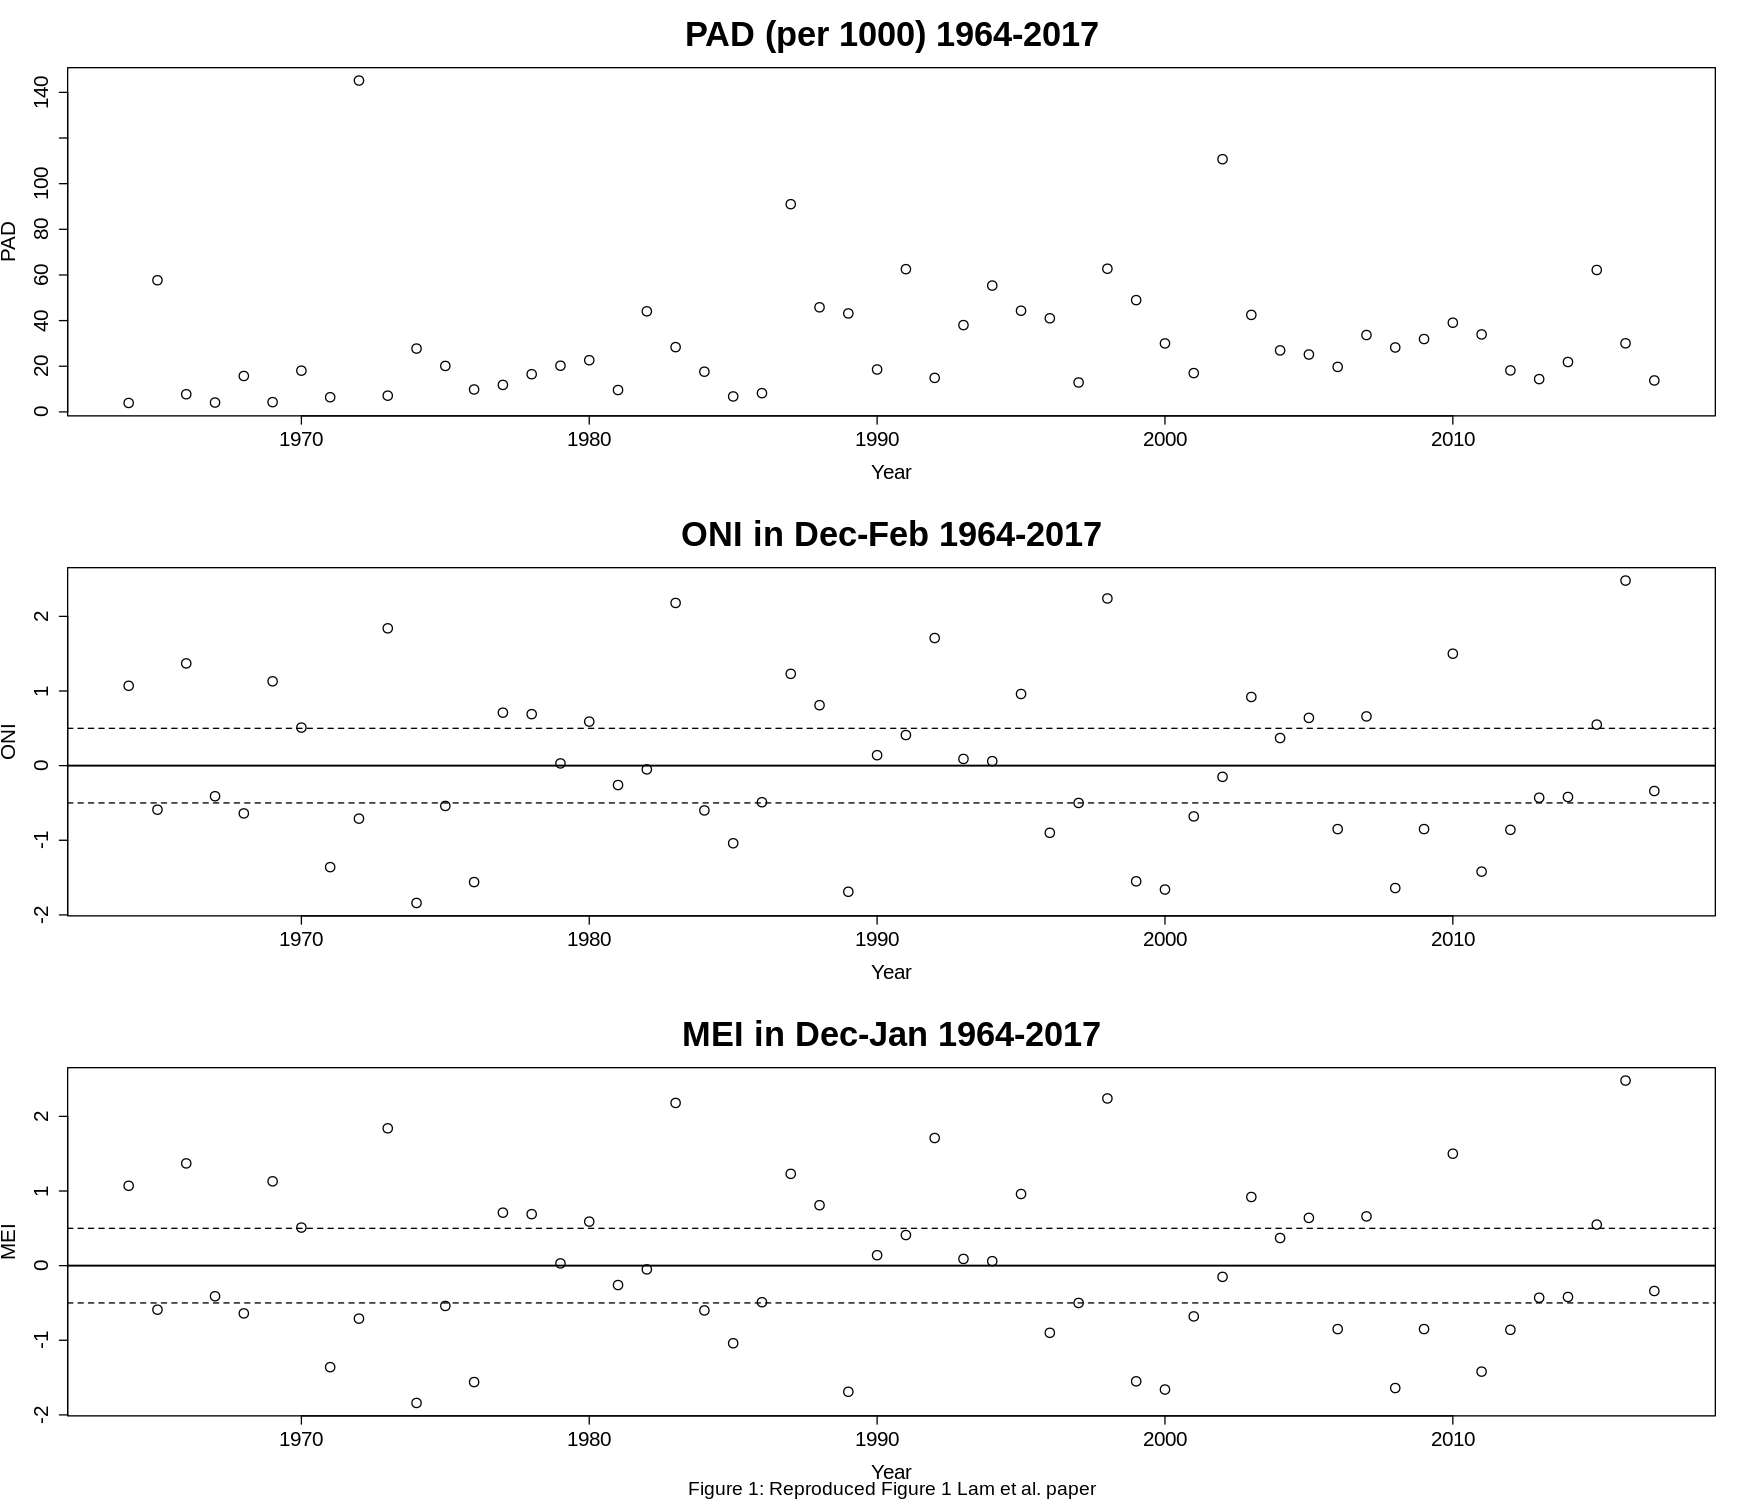

In [ ]:
options(repr.plot.width=14, repr.plot.height=12, repr.plot.res = 125)

par(mfrow = c(3,1), cex.main =  2.5, cex.lab = 1.5, cex.axis = 1.5, cex.sub = 1.4)

plot(years, pad_per_1000_values, type = 'p', xlab = 'Year', ylab = 'PAD', main = "PAD (per 1000) 1964-2017", cex = 1.5)

plot(years, oni_subset, type = 'p', xlab = 'Year', ylab = 'ONI', main = "ONI in Dec-Feb 1964-2017", cex = 1.5)
abline(h = 0, lwd=1.5, lty=1)
abline(h = 0.5, lwd=1, lty=2)
abline(h = -0.5, lwd=1, lty=2)

plot(years, mei_subset, type = 'p', xlab = 'Year', ylab = 'MEI', main = "MEI in Dec-Jan 1964-2017", sub = "Figure 1: Reproduced Figure 1 Lam et al. paper", cex = 1.5)
abline(h = 0, lwd=1.5, lty=1)
abline(h = 0.5, lwd=1, lty=2)
abline(h = -0.5, lwd=1, lty=2)

### 4.2 Investigate all the data

#### 4.2.1 ONI Investigation

##### 4.2.1.1 ONI Realization

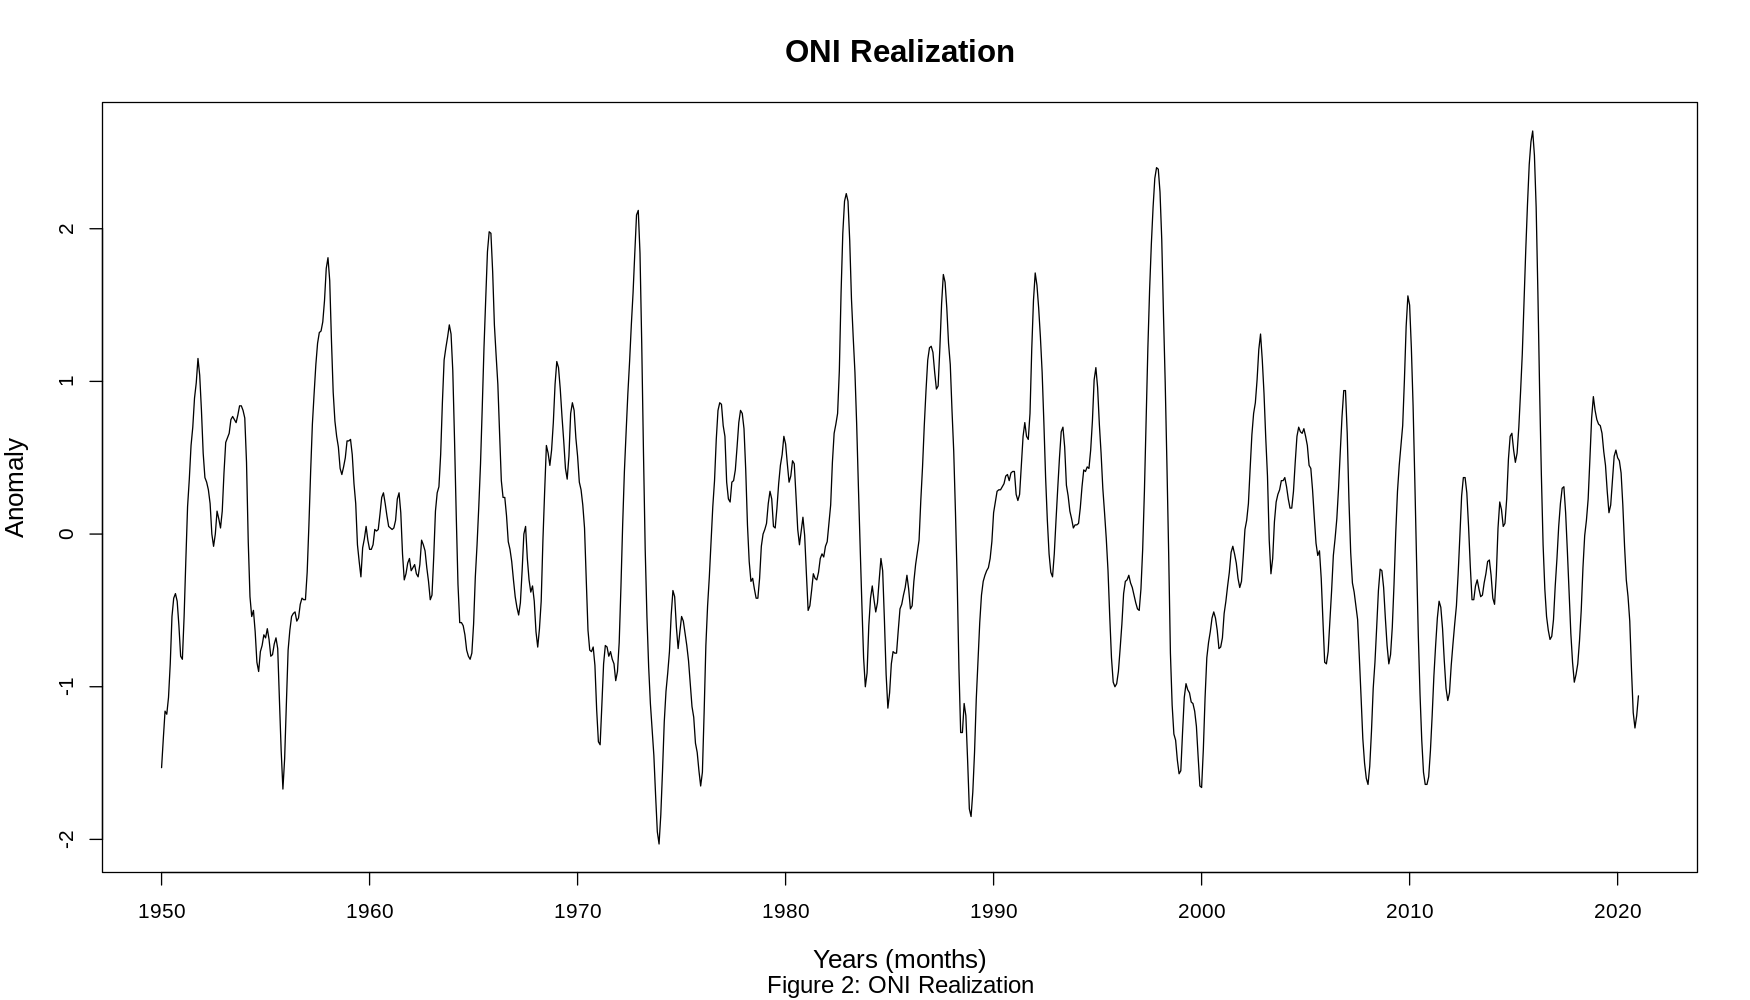

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25, cex.sub = 1.15)
plot(oni.ts, type ='l', lty = 1, xlab = 'Years (months)', 
    ylab = 'Anomaly', main='ONI Realization', 
    sub = "Figure 2: ONI Realization")

##### 4.2.1.2 ONI Periodogram

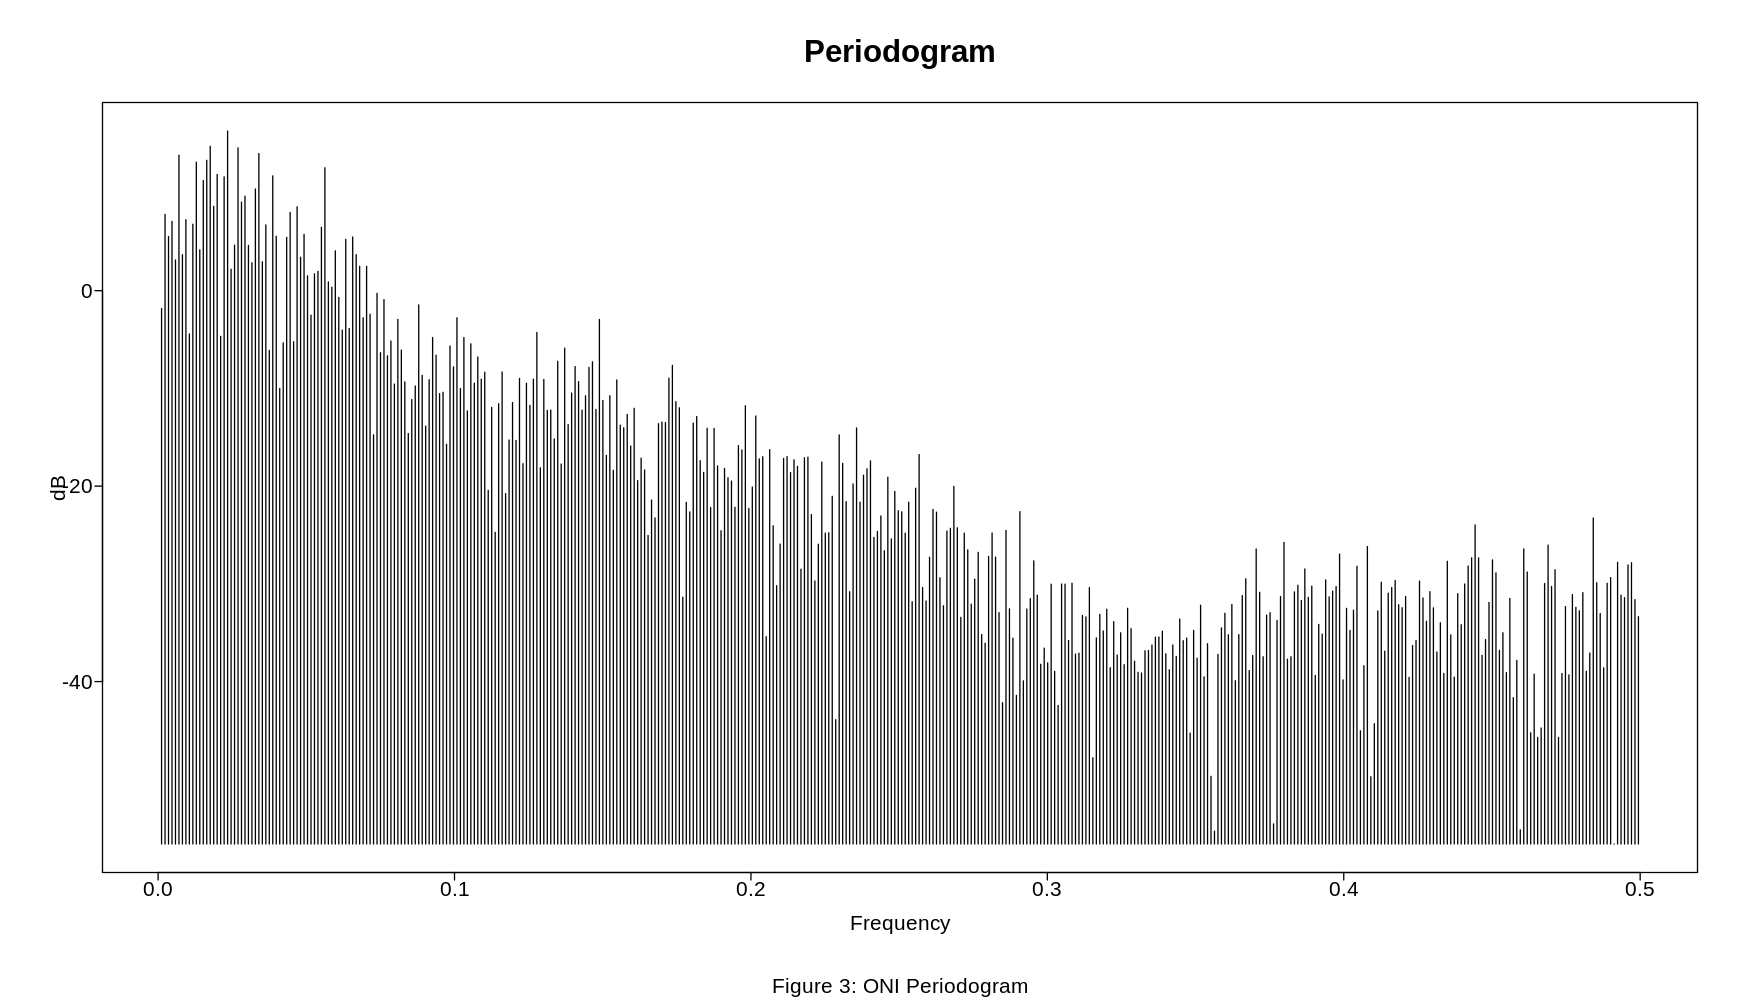

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25)
oni_periodogram <- period.wge(oni.df$ANOM)
title(sub = "Figure 3: ONI Periodogram")

##### 4.2.1.3 ONI Parzen Window

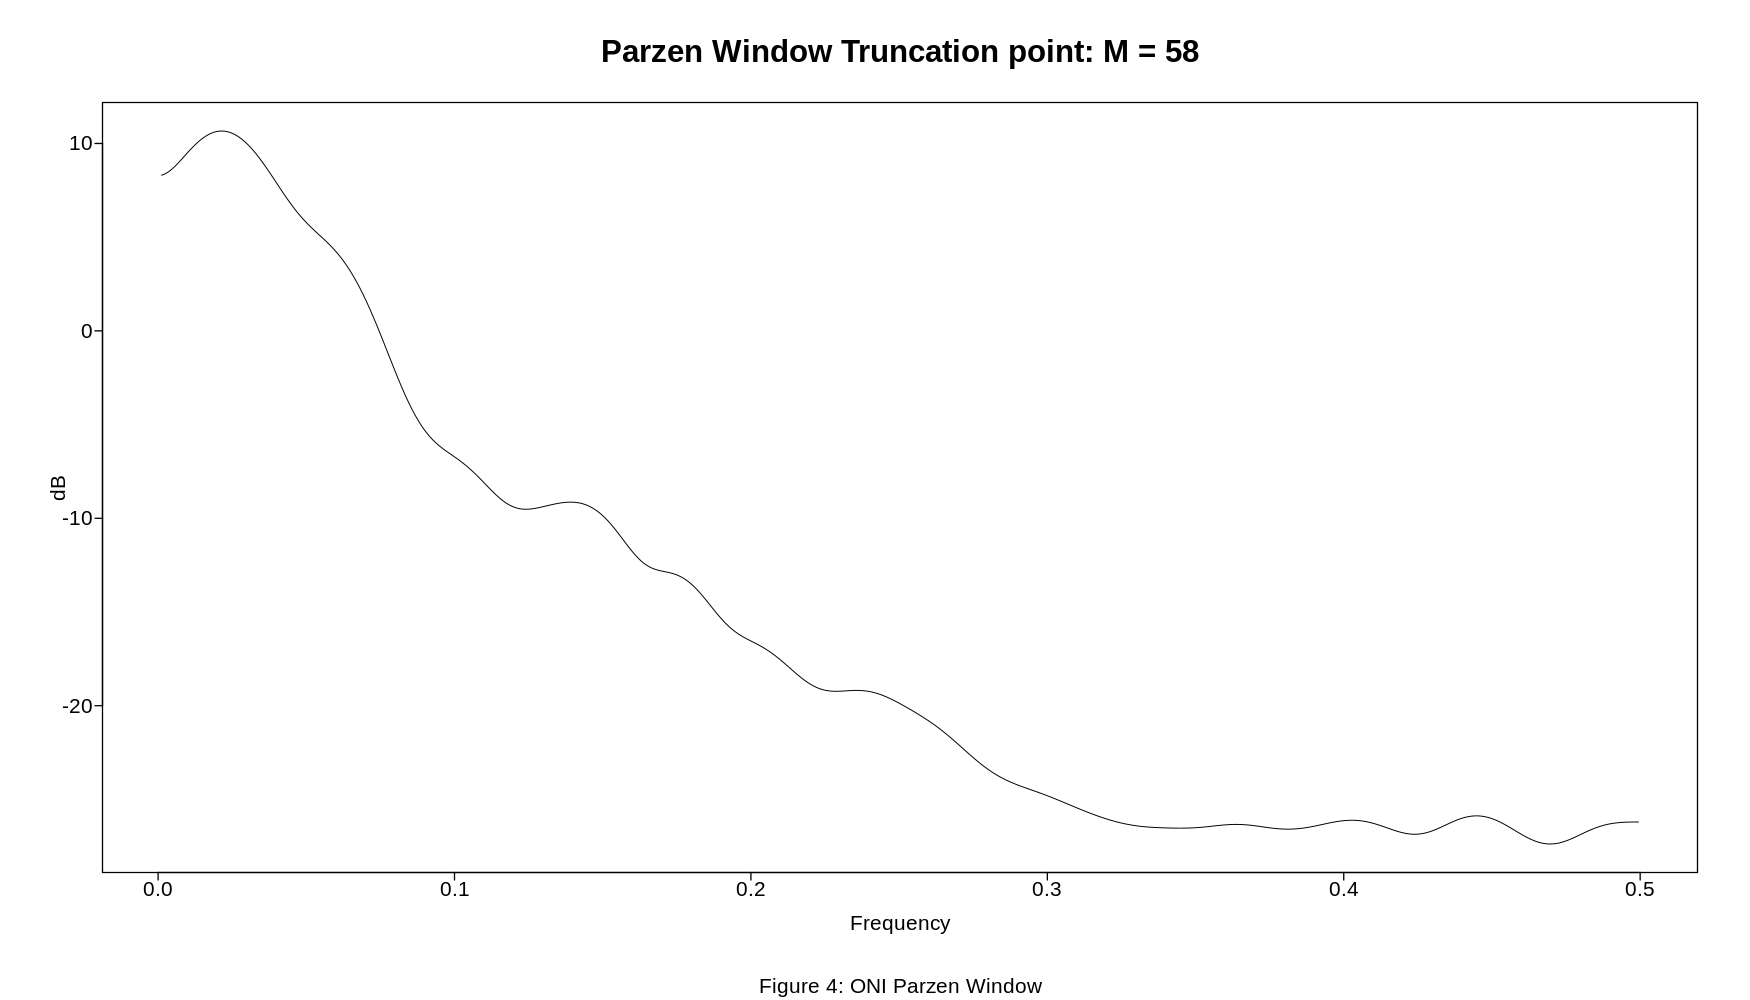

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25)
oni_parzen_window <- parzen.wge(oni.df$ANOM)
title(sub = "Figure 4: ONI Parzen Window")

##### 4.2.1.4 ONI Dominant Frequency and Periodic/Aperiodic Behavior

In [ ]:
cat("ONI Dominant Frequency: ", oni_periodogram$freq[which.max(oni_periodogram$pgram)], "\n")
cat("ONI Period: ", 1/oni_periodogram$freq[which.max(oni_periodogram$pgram)], "\n")

ONI Dominant Frequency:  0.02344666 
ONI Period:  42.65 


##### 4.2.1.5 ONI Autocorrelation

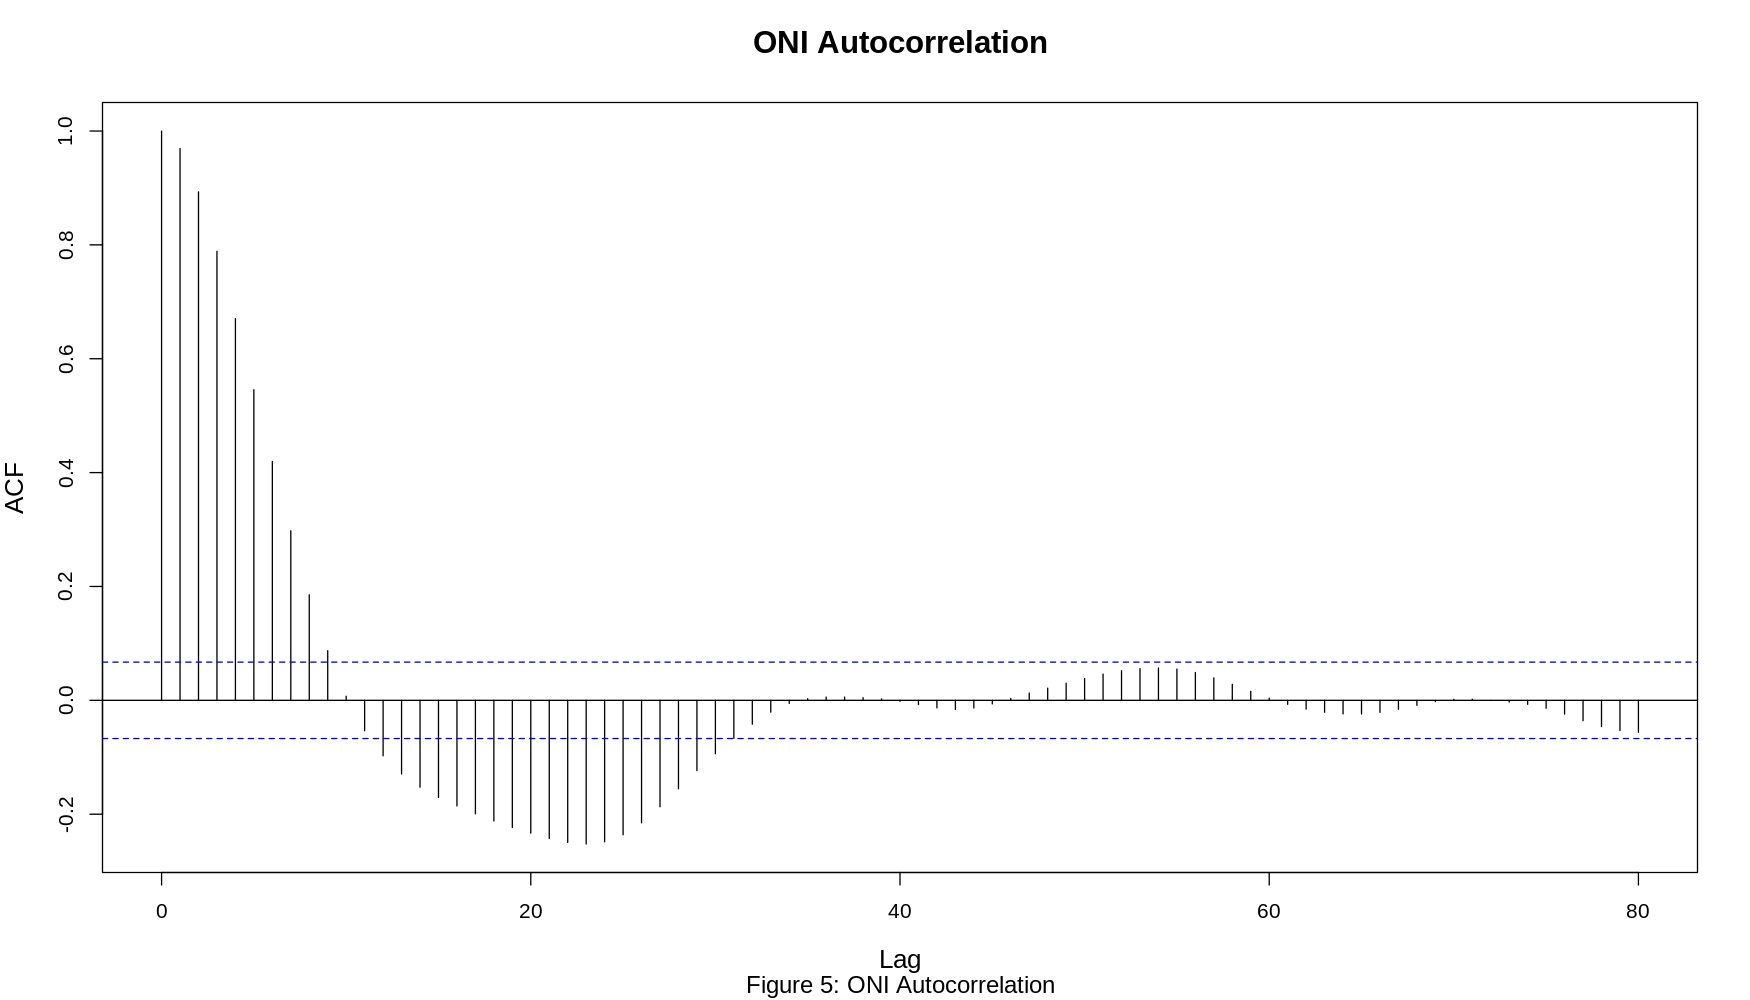

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25, cex.sub = 1.15)
acf(oni.df$ANOM, main = 'ONI Autocorrelation', sub = 'Figure 5: ONI Autocorrelation', lag.max = 80)

#### 4.2.2 MEI Investigation

##### 4.2.2.1 MEI Realization

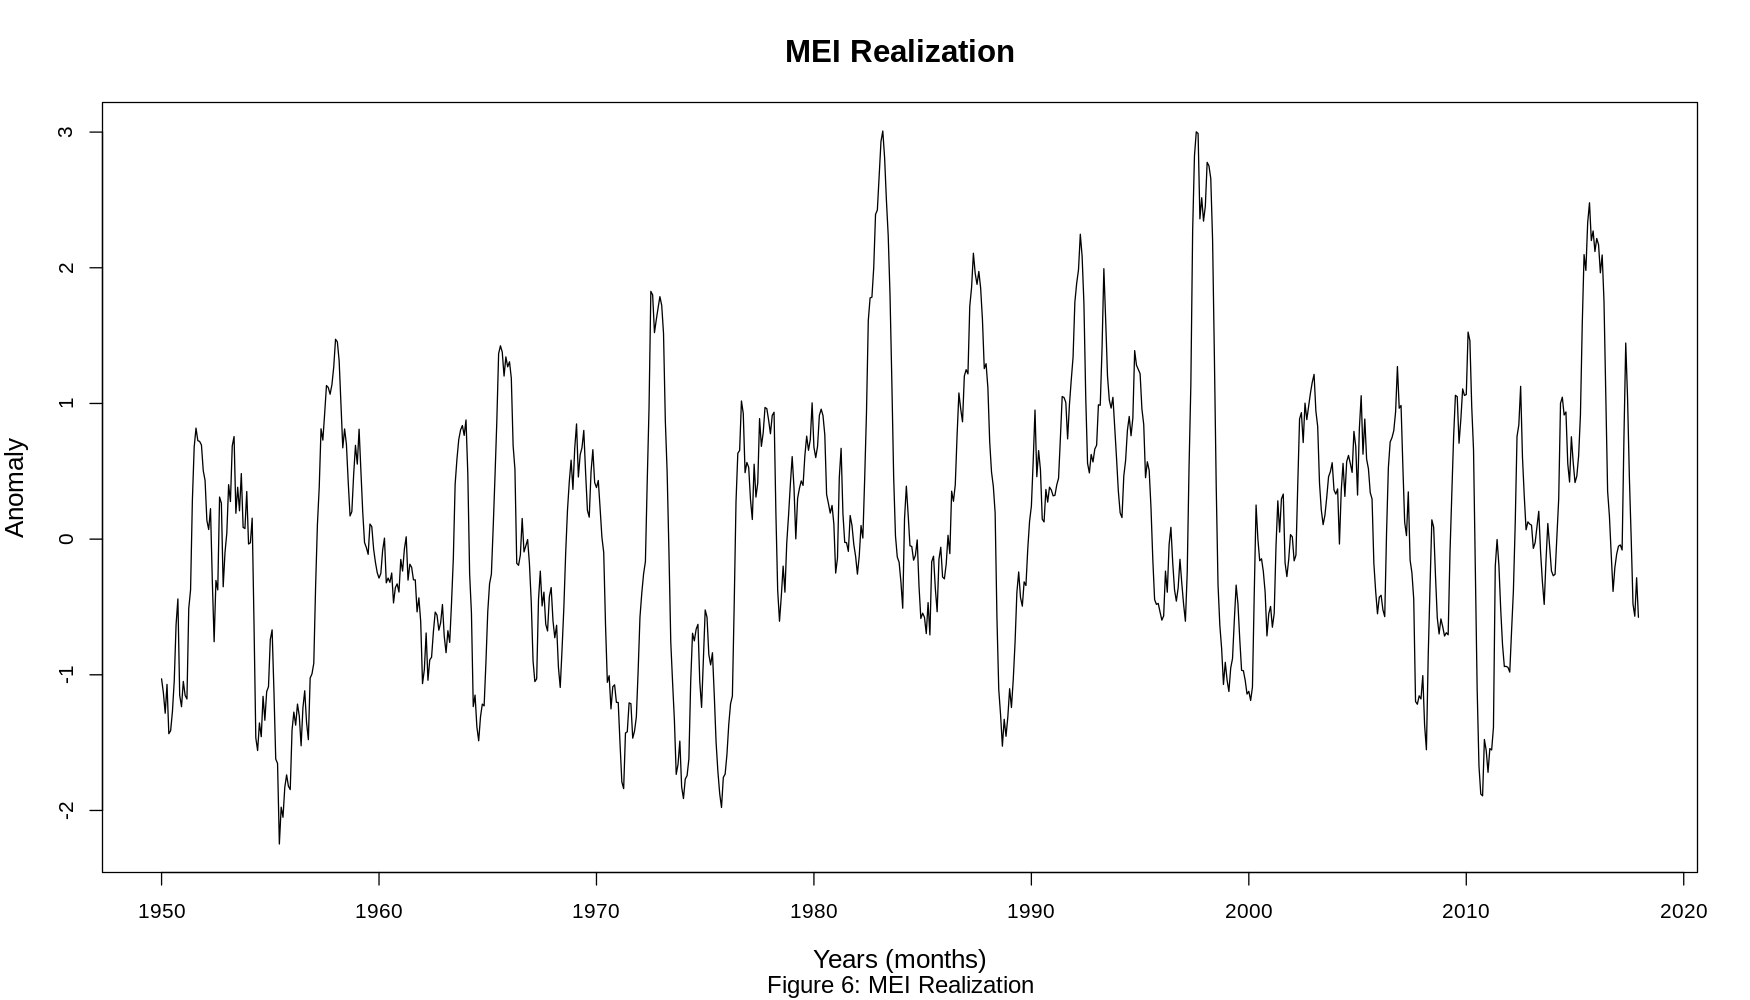

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25, cex.sub = 1.15)
plot(mei.ts, type ='l', lty = 1, xlab = 'Years (months)', 
    ylab = 'Anomaly', main='MEI Realization', 
    sub = "Figure 6: MEI Realization")

##### 4.2.2.2 MEI Periodogram

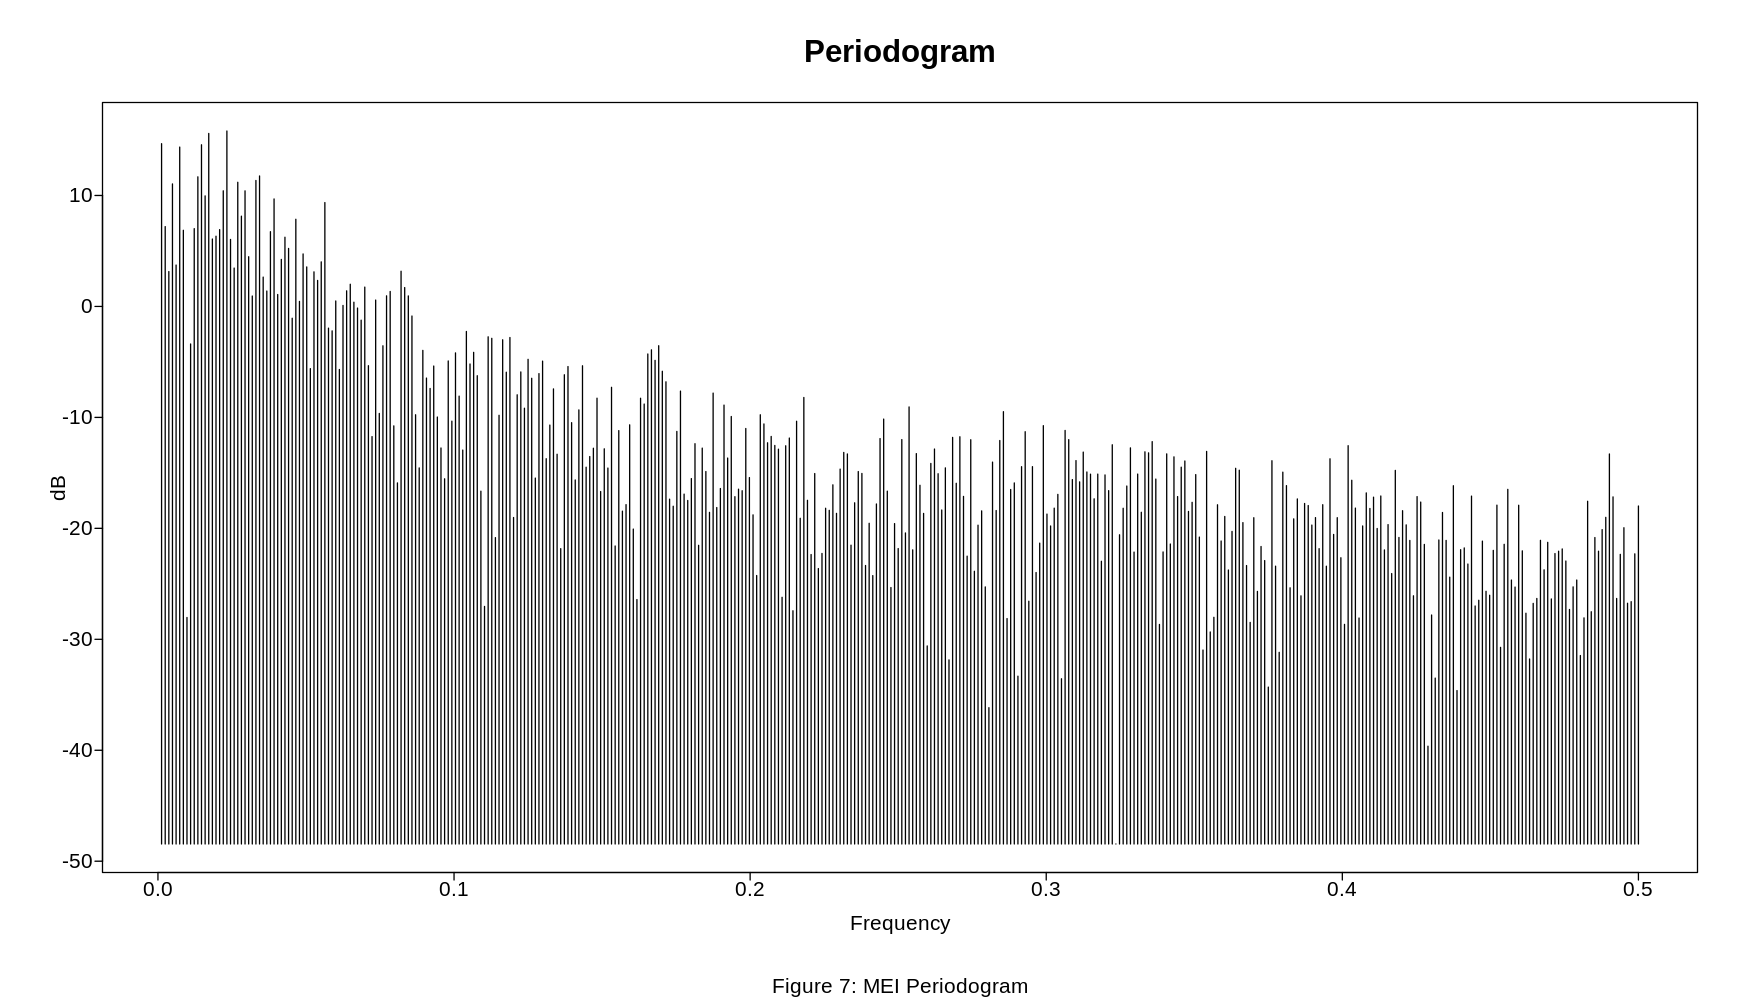

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25)
mei_periodogram <- period.wge(mei.ts)
title(sub = "Figure 7: MEI Periodogram")

##### 4.2.2.3 MEI Parzen Window

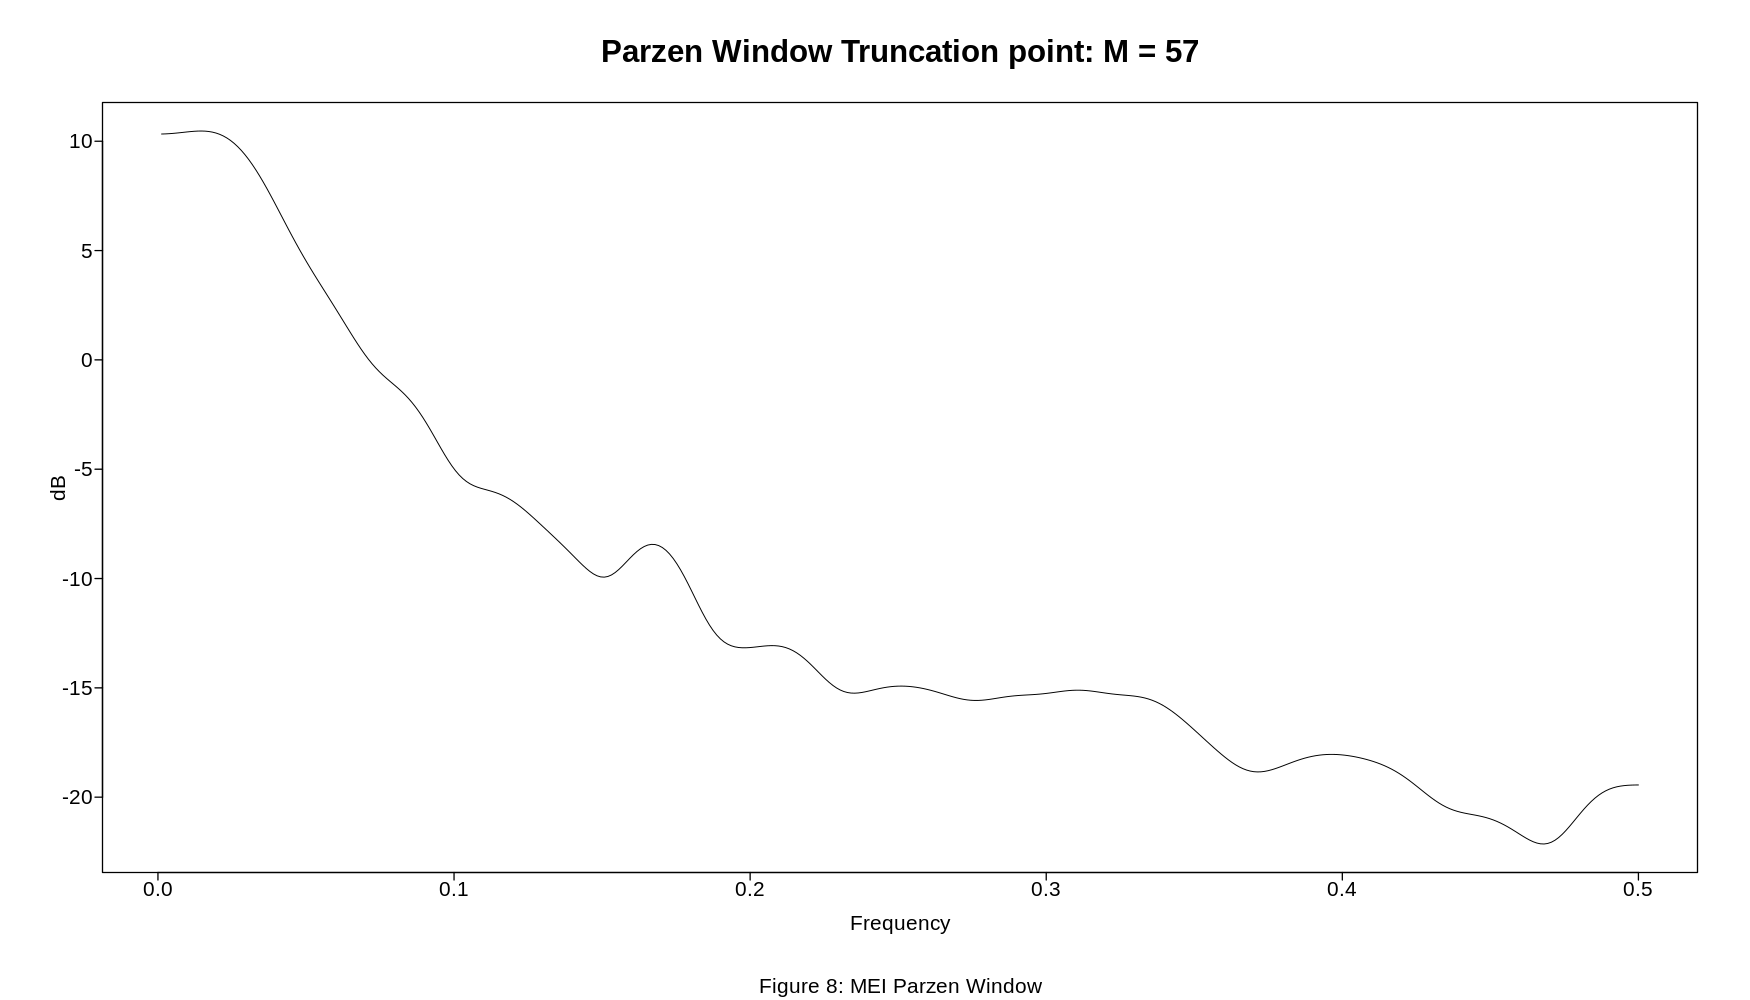

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25)
mei_parzen_window <- parzen.wge(mei.ts)
title(sub = "Figure 8: MEI Parzen Window")

##### 4.2.2.4 MEI Dominant Frequency and Periodic/Aperiodic Behavior

In [ ]:
cat("MEI Dominant Frequency: ", mei_periodogram$freq[which.max(mei_periodogram$pgram)], "\n")
cat("MEI Period: ", 1/mei_periodogram$freq[which.max(mei_periodogram$pgram)], "\n")

MEI Dominant Frequency:  0.02328431 
MEI Period:  42.94737 


##### 4.2.2.5 MEI Autocorrelation

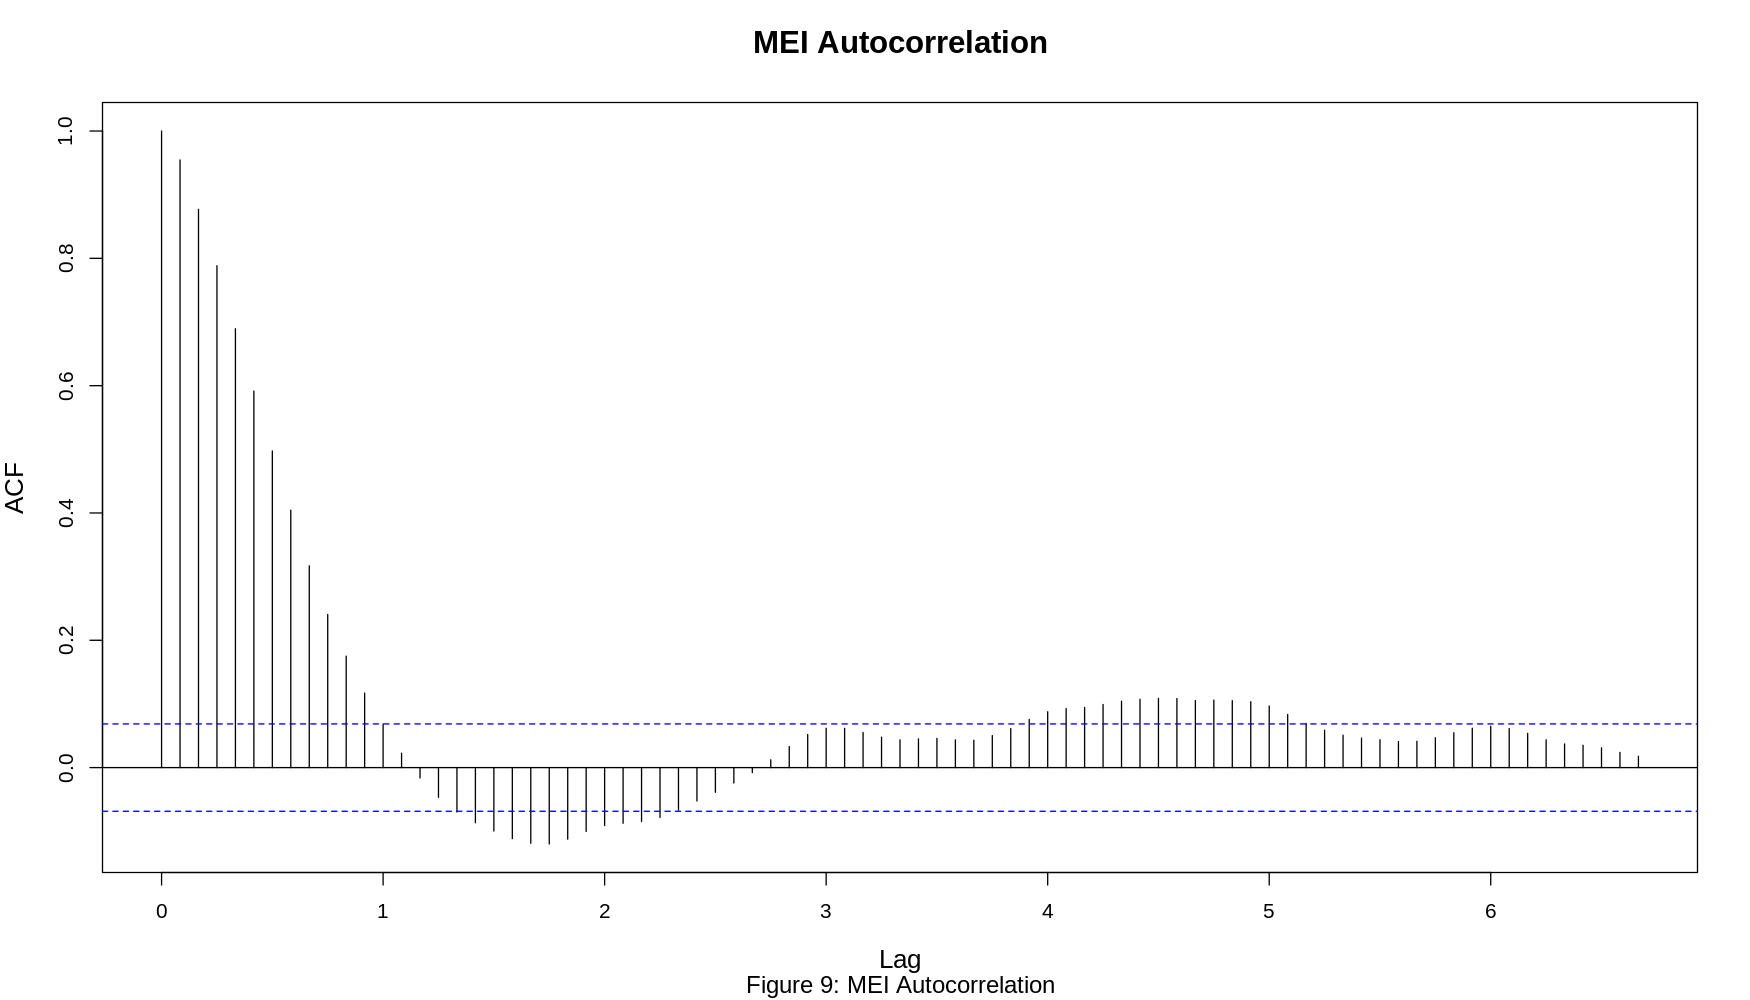

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25, cex.sub = 1.15)
acf(mei.ts, main = 'MEI Autocorrelation', sub = 'Figure 9: MEI Autocorrelation', lag.max = 80)

#### 4.2.3 PAD Investigation

##### 4.2.3.1 PAD Realization

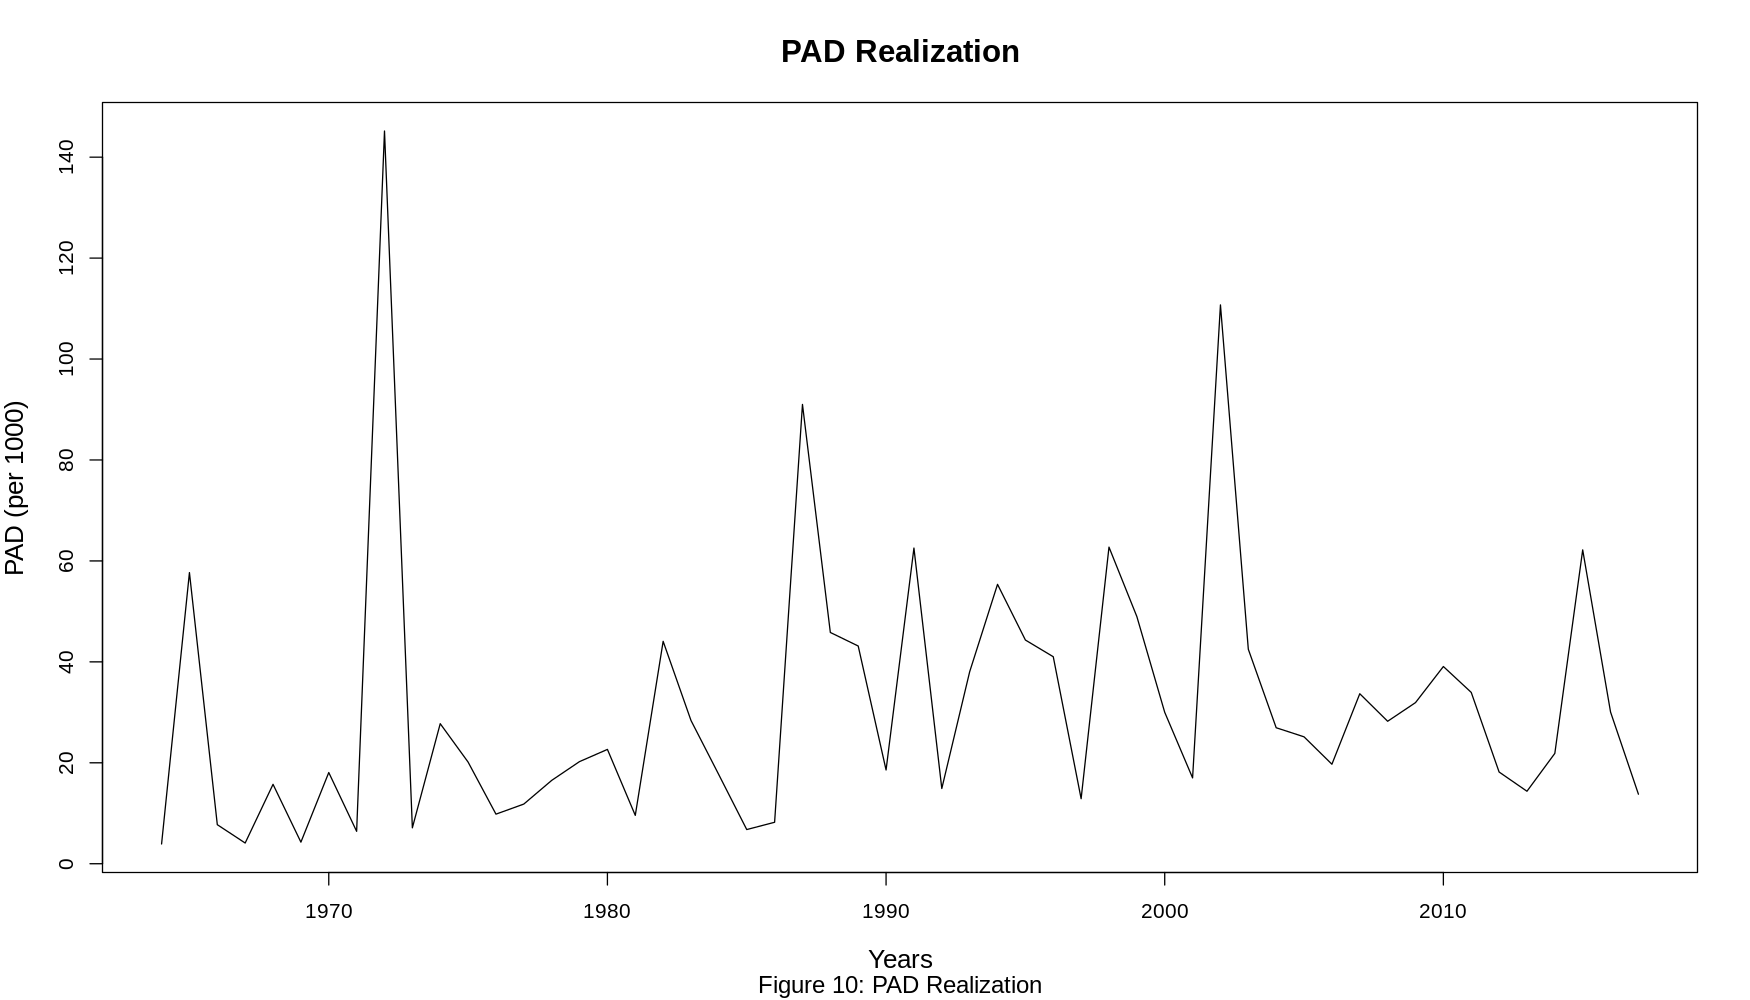

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25, cex.sub = 1.15)
plot(pad.ts, type ='l', lty = 1, xlab = 'Years', 
    ylab = 'PAD (per 1000)', main='PAD Realization', 
    sub = "Figure 10: PAD Realization")

##### 4.2.3.2 PAD Periodogram

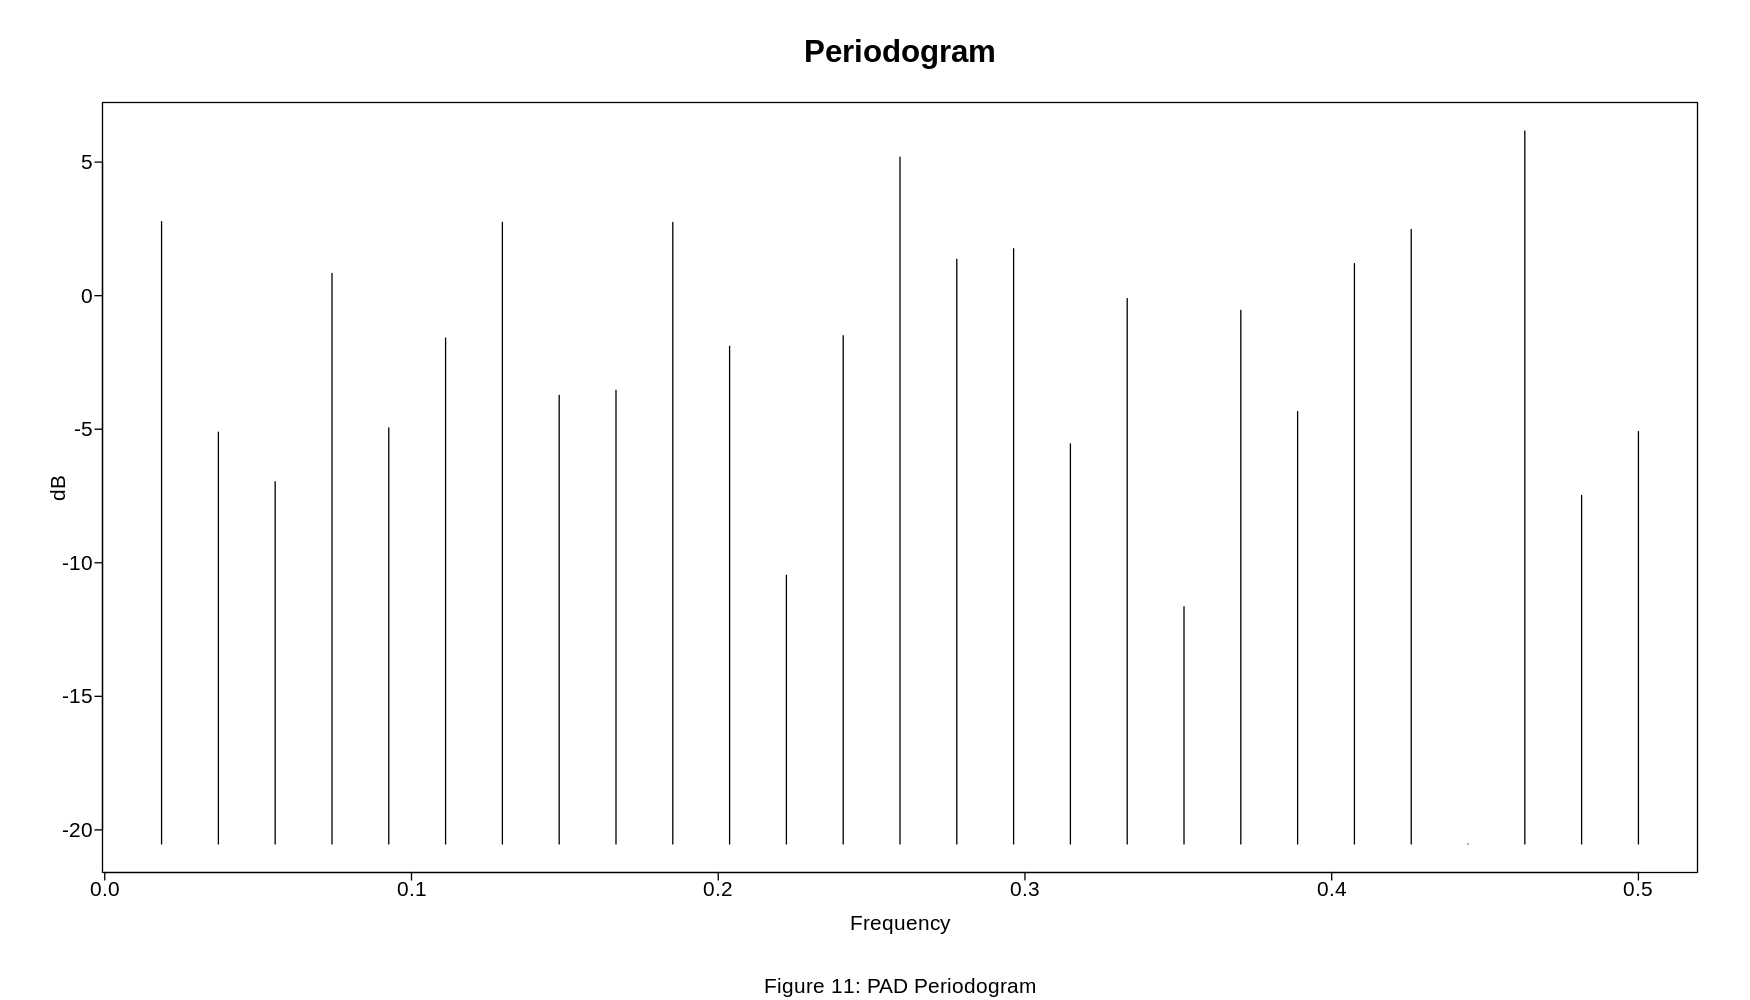

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25)
pad_periodogram <- period.wge(pad.ts)
title(sub = "Figure 11: PAD Periodogram")

##### 4.2.3.3 PAD Parzen Window

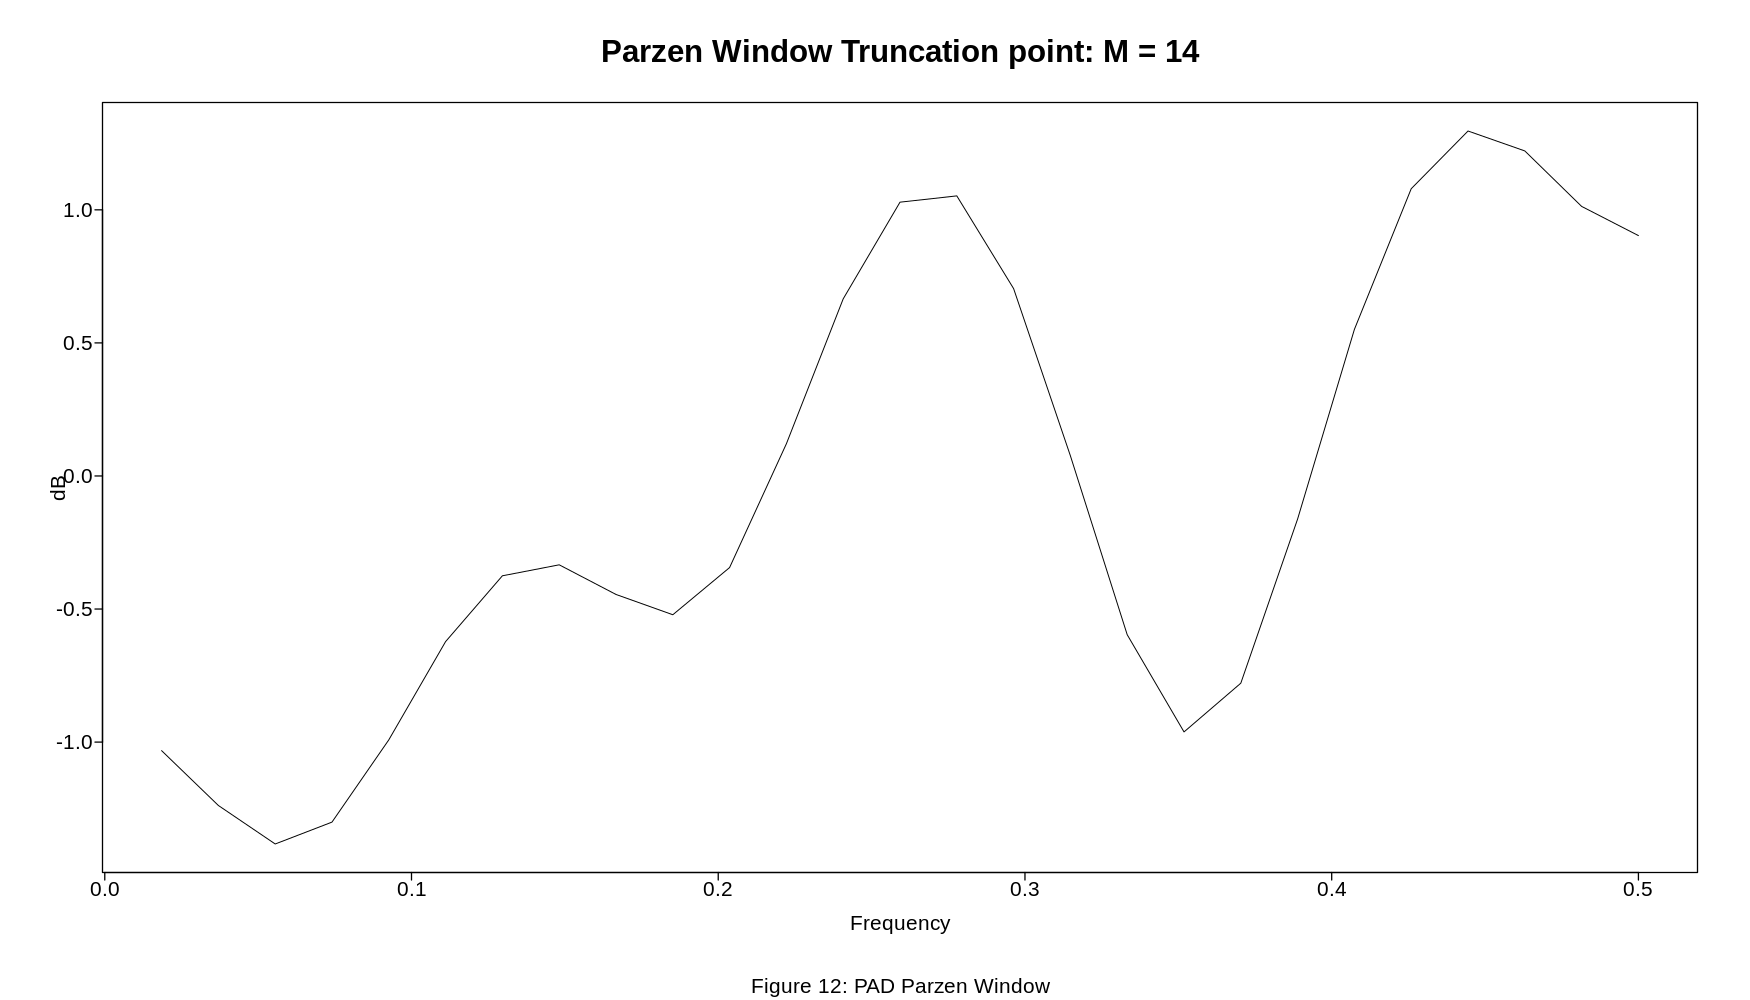

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25)
pad_parzen_window <- parzen.wge(pad.ts)
title(sub = "Figure 12: PAD Parzen Window")

##### 4.2.3.4 PAD Dominant Frequency and Periodic/Aperiodic Behavior

In [ ]:
f1 <- pad_periodogram$freq[which.max(pad_periodogram$pgram)]

f <- pad_periodogram$freq[pad_periodogram$freq > 0.2 & pad_periodogram$freq < 0.3]
pgram <- pad_periodogram$pgram[pad_periodogram$freq > 0.2 & pad_periodogram$freq < 0.3]
f2 <- f[which.max(pgram)]

f <- pad_periodogram$freq[pad_periodogram$freq > 0.1 & pad_periodogram$freq < 0.2]
pgram <- pad_periodogram$pgram[pad_periodogram$freq > 0.1 & pad_periodogram$freq < 0.2]
f3 <- f[which.max(pgram)]


cat("PAD Dominant Frequency: ", f1, "\n")
cat("PAD Second Dominant Frequency: ", f2, "\n")
cat("PAD Third Dominant Frequency: ", f3, "\n")
cat("\n")
cat("\n")
cat("PAD Period: ", 1/f1, "\n")
cat("PAD Second Period: ", 1/f2, "\n")
cat("PAD Third Period: ", 1/f3, "\n")

PAD Dominant Frequency:  0.462963 
PAD Second Dominant Frequency:  0.2592593 
PAD Third Dominant Frequency:  0.1296296 


PAD Period:  2.16 
PAD Second Period:  3.857143 
PAD Third Period:  7.714286 


##### 4.2.3.5 PAD Autocorrelation

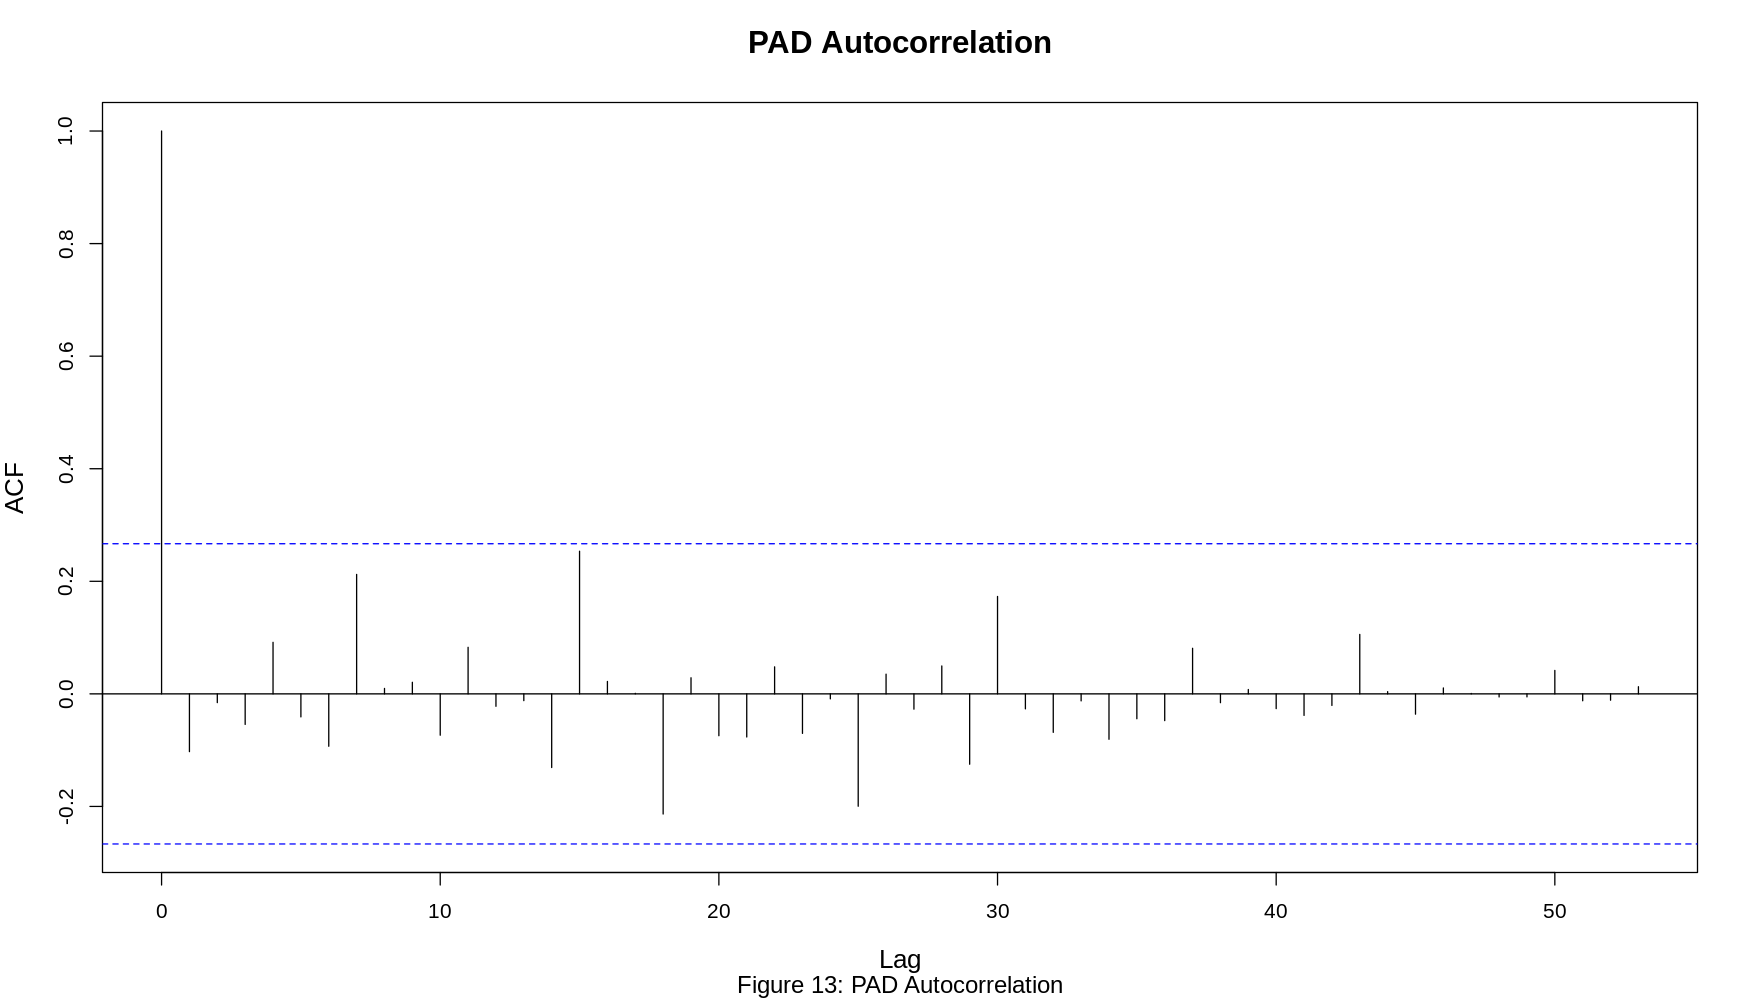

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25, cex.sub = 1.15)
acf(pad.ts, main = 'PAD Autocorrelation', sub = 'Figure 13: PAD Autocorrelation', lag.max = 80)

### 4.3 El Niño Years

#### 4.3.1 El Niño Years Realization

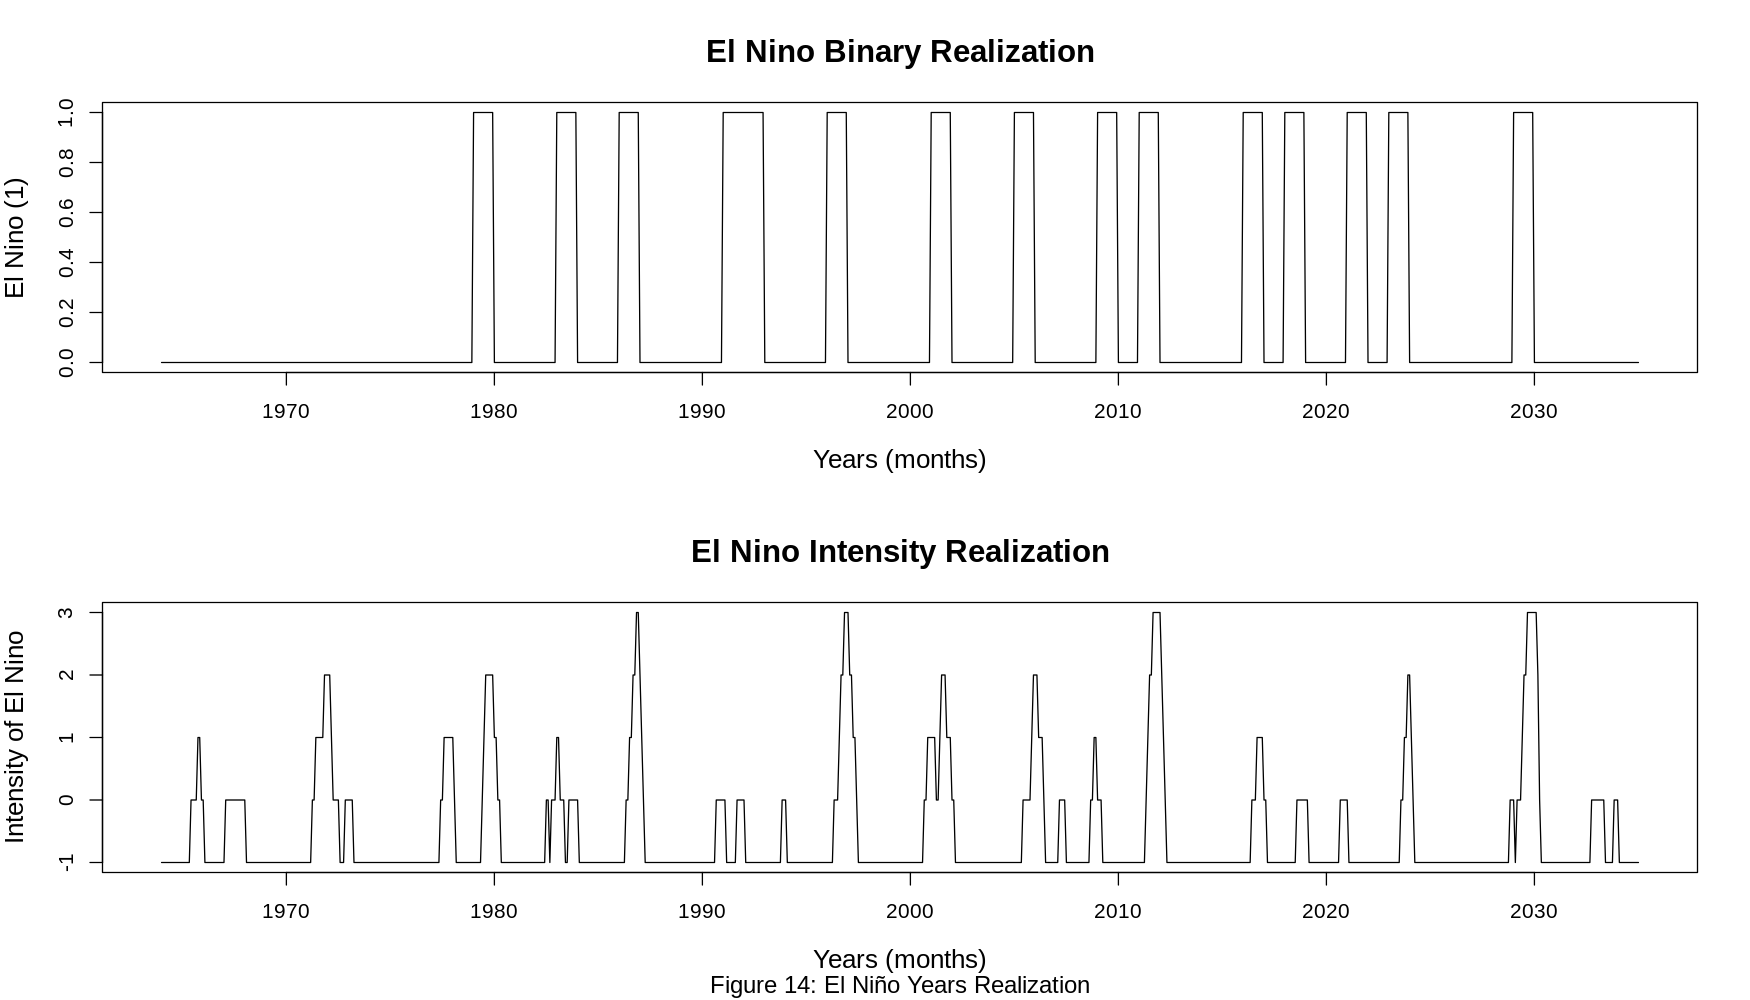

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)

par(mfrow = c(2,1), cex.main =  1.5, cex.lab = 1.25, cex.axis = 1, cex.sub = 1.15)

plot(el_nino.ts, type = 'l', xlab ='Years (months)', ylab='El Nino (1)', main ='El Nino Binary Realization')

plot(intensity.ts, type = 'l', xlab ='Years (months)', ylab='Intensity of El Nino', main ='El Nino Intensity Realization', sub = "Figure 14: El Niño Years Realization")

#### 4.3.2 El Niño Years Periodogram

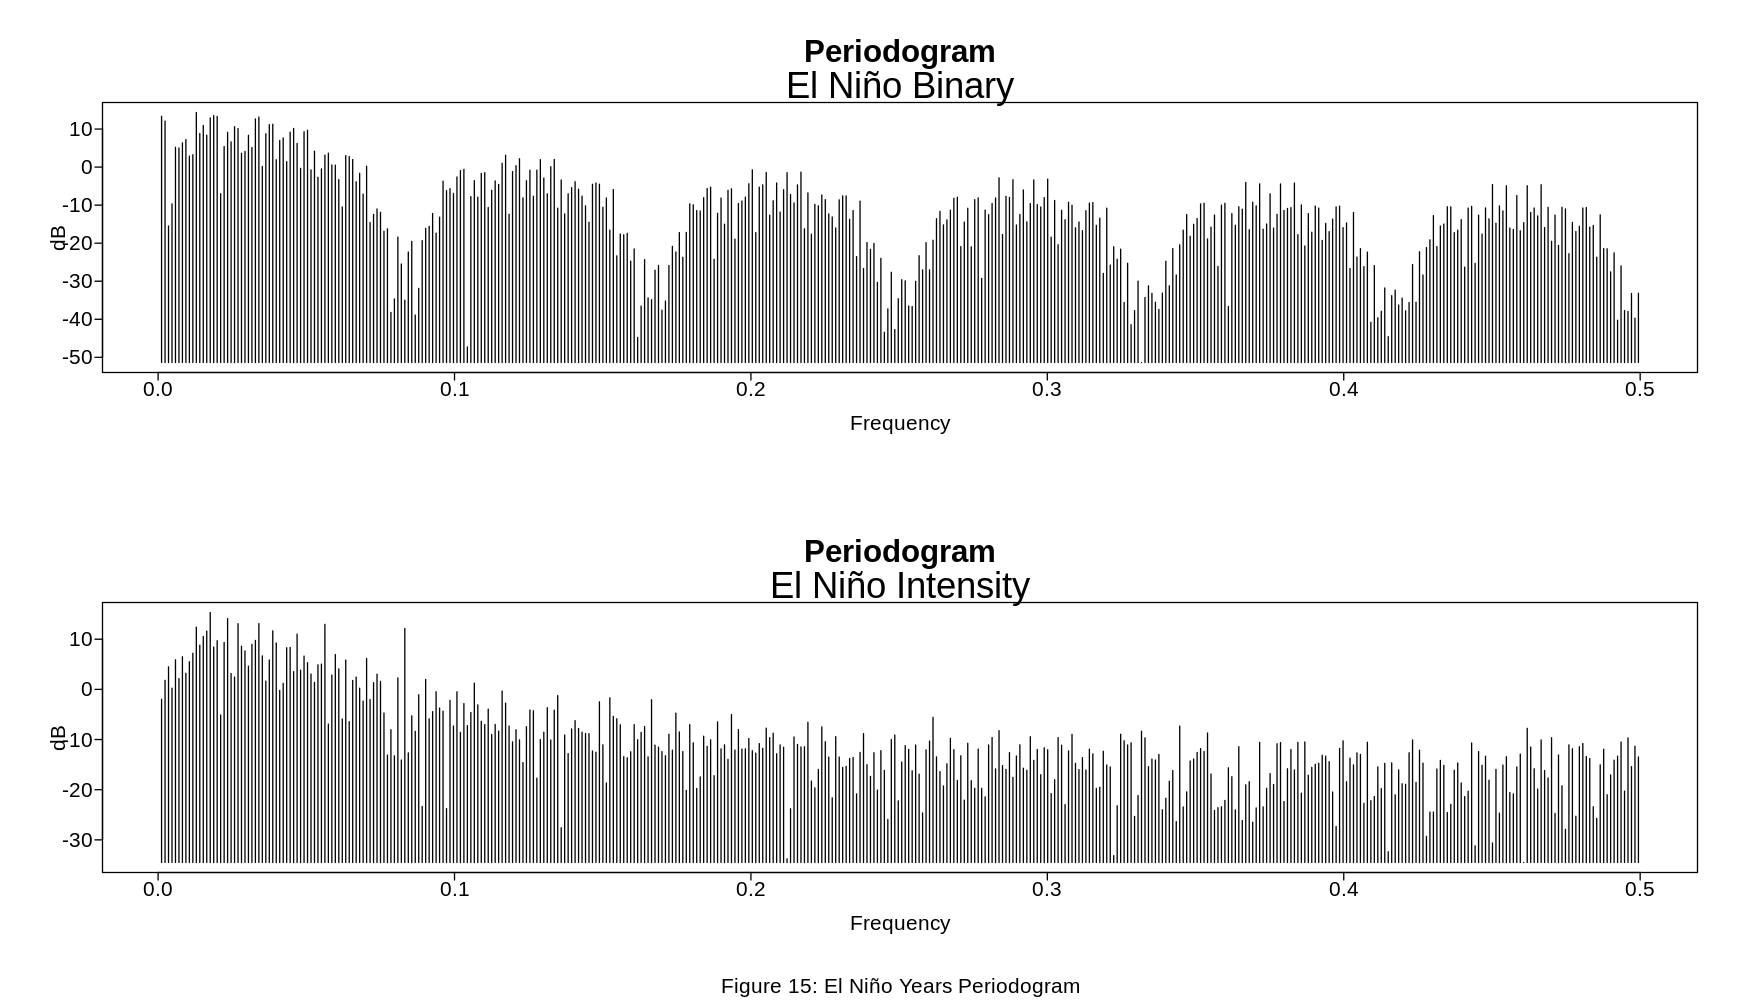

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(mfrow = c(2,1),cex.main =  1.5, cex.lab = 1.25)

el_nino_periodogram <- period.wge(el_nino.ts)

mtext("El Niño Binary", cex = 1.75, side=3)

intensity_periodogram <- period.wge(intensity.ts)

mtext("El Niño Intensity", cex = 1.75, side=3)

title(sub = "Figure 15: El Niño Years Periodogram")

#### 4.3.3 El Niño Years Parzen Window

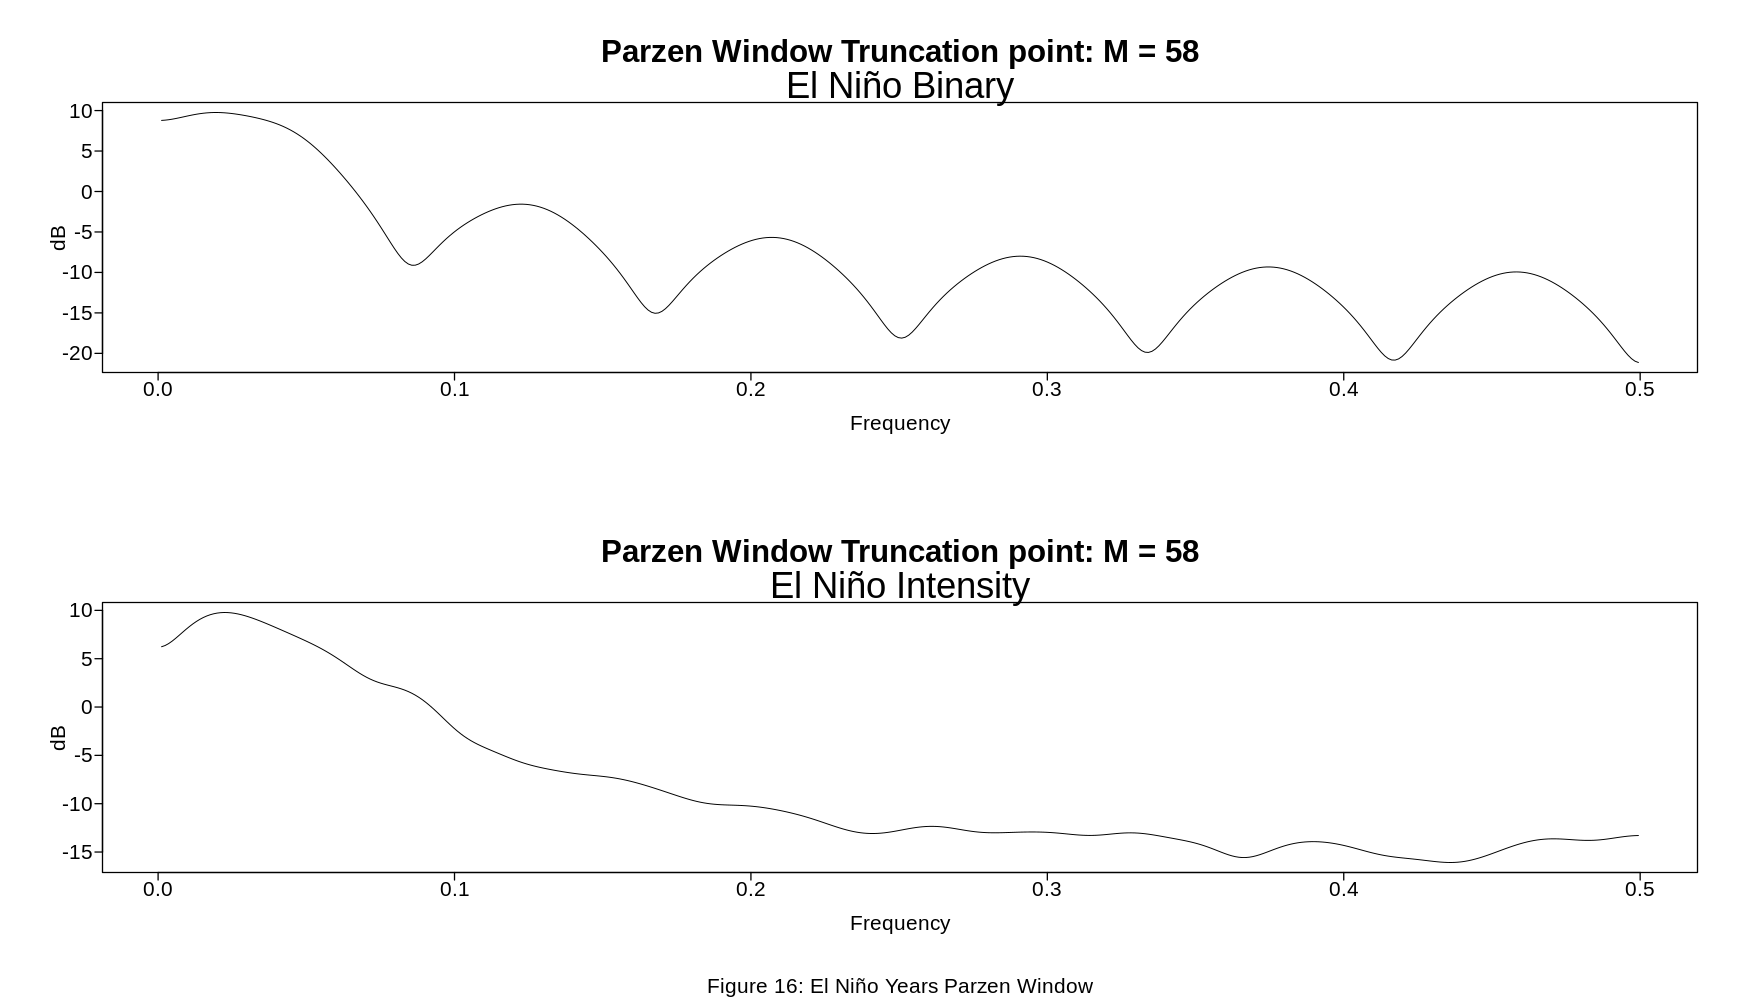

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(mfrow = c(2,1),cex.main =  1.5, cex.lab = 1.25)

el_nino_parzen_window <- parzen.wge(el_nino.ts)

mtext("El Niño Binary", cex = 1.75, side=3)

intensity_parzen_window <- parzen.wge(intensity.ts)

mtext("El Niño Intensity", cex = 1.75, side=3)

title(sub = "Figure 16: El Niño Years Parzen Window")

#### 4.3.4 El Niño Years Dominant Frequency and Periodic/Aperiodic Behavior

In [ ]:
cat("El Niño Binary Dominant Frequency: ", el_nino_periodogram$freq[which.max(el_nino_periodogram$pgram)], "\n")
cat("El Niño Binary Period: ", 1/el_nino_periodogram$freq[which.max(el_nino_periodogram$pgram)], "\n")
cat("The period is in terms of months, so El Niño years occur around every 6 years according to this.")

cat("\n")
cat("\n")

cat("El Niño Intensity Dominant Frequency: ", intensity_periodogram$freq[which.max(intensity_periodogram$pgram)], "\n")
cat("El Niño Intensity Period: ", 1/intensity_periodogram$freq[which.max(intensity_periodogram$pgram)], "\n")
cat("The period is in terms of months, so El Niño years occur around every 4.7 years according to this.")

El Niño Binary Dominant Frequency:  0.01289566 
El Niño Binary Period:  77.54545 
The period is in terms of months, so El Niño years occur around every 6 years according to this.

El Niño Intensity Dominant Frequency:  0.01758499 
El Niño Intensity Period:  56.86667 
The period is in terms of months, so El Niño years occur around every 4.7 years according to this.

#### 4.3.5 El Niño Years Autocorrelation

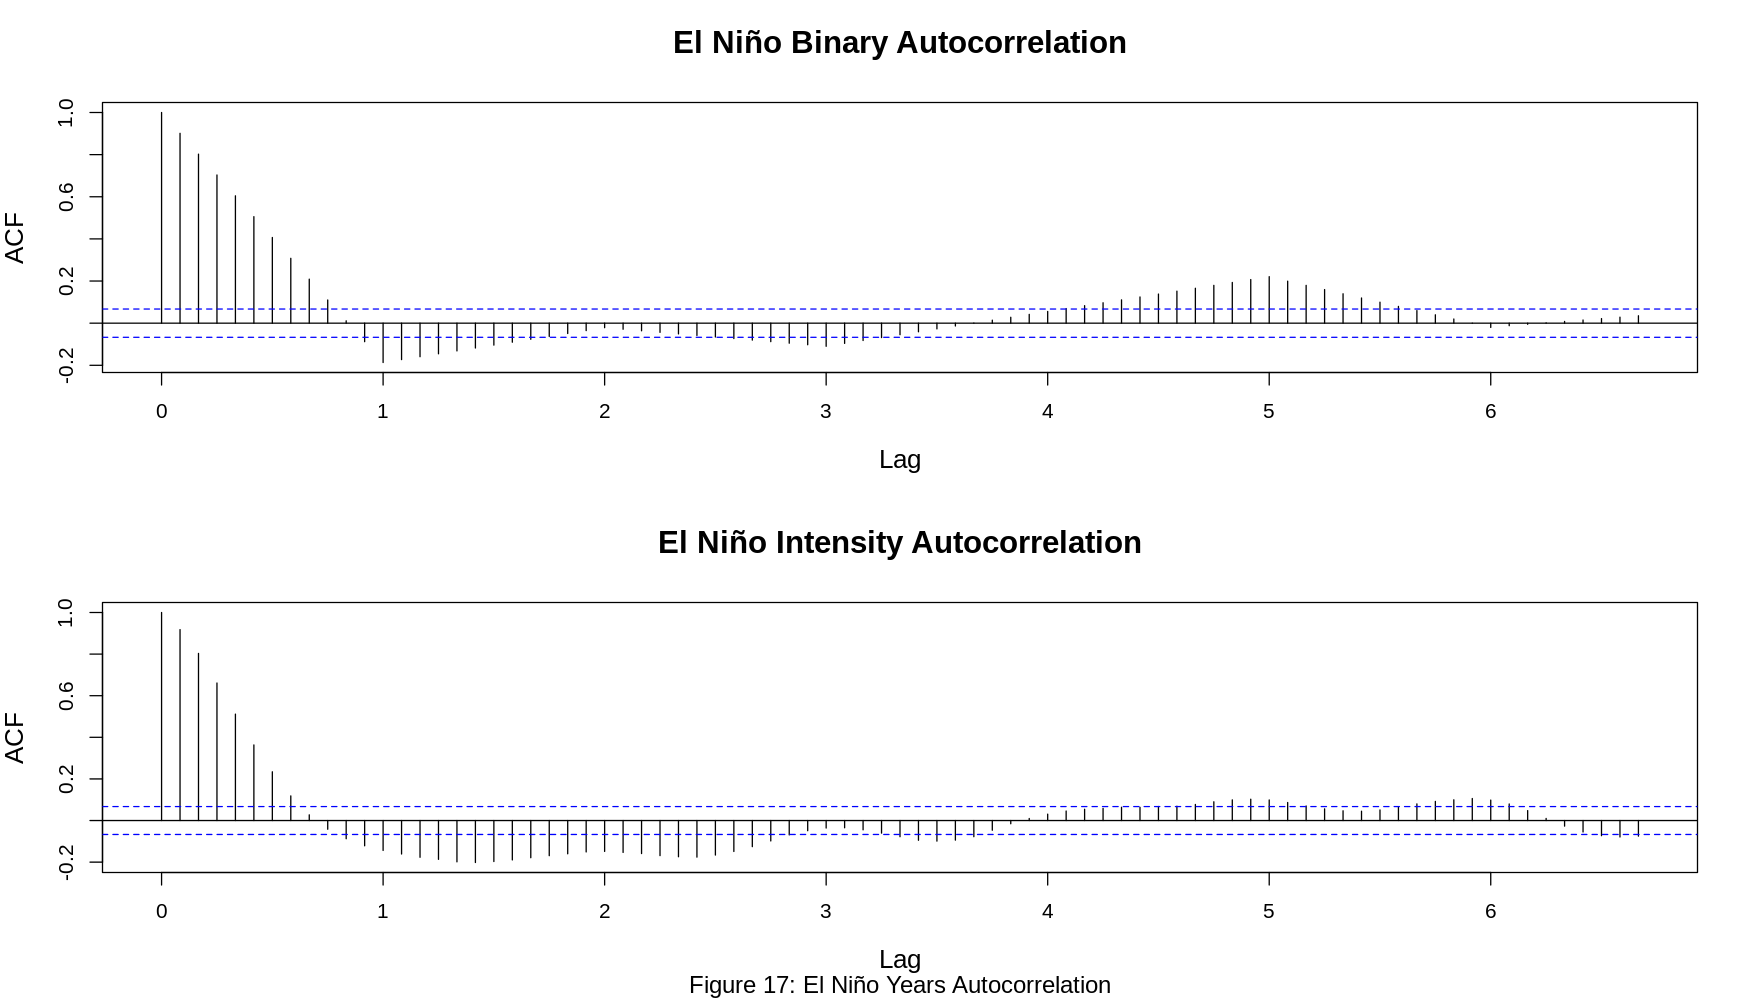

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(mfrow = c(2,1),cex.main =  1.5, cex.lab = 1.25, cex.sub = 1.15)
acf(el_nino.ts, main = 'El Niño Binary Autocorrelation', lag.max = 80)
acf(intensity.ts, main = 'El Niño Intensity Autocorrelation', sub = 'Figure 17: El Niño Years Autocorrelation', lag.max = 80)

### 4.4 North Atlantic Oscillation (NAO) Investigation


#### 4.4.1 NAO Realization

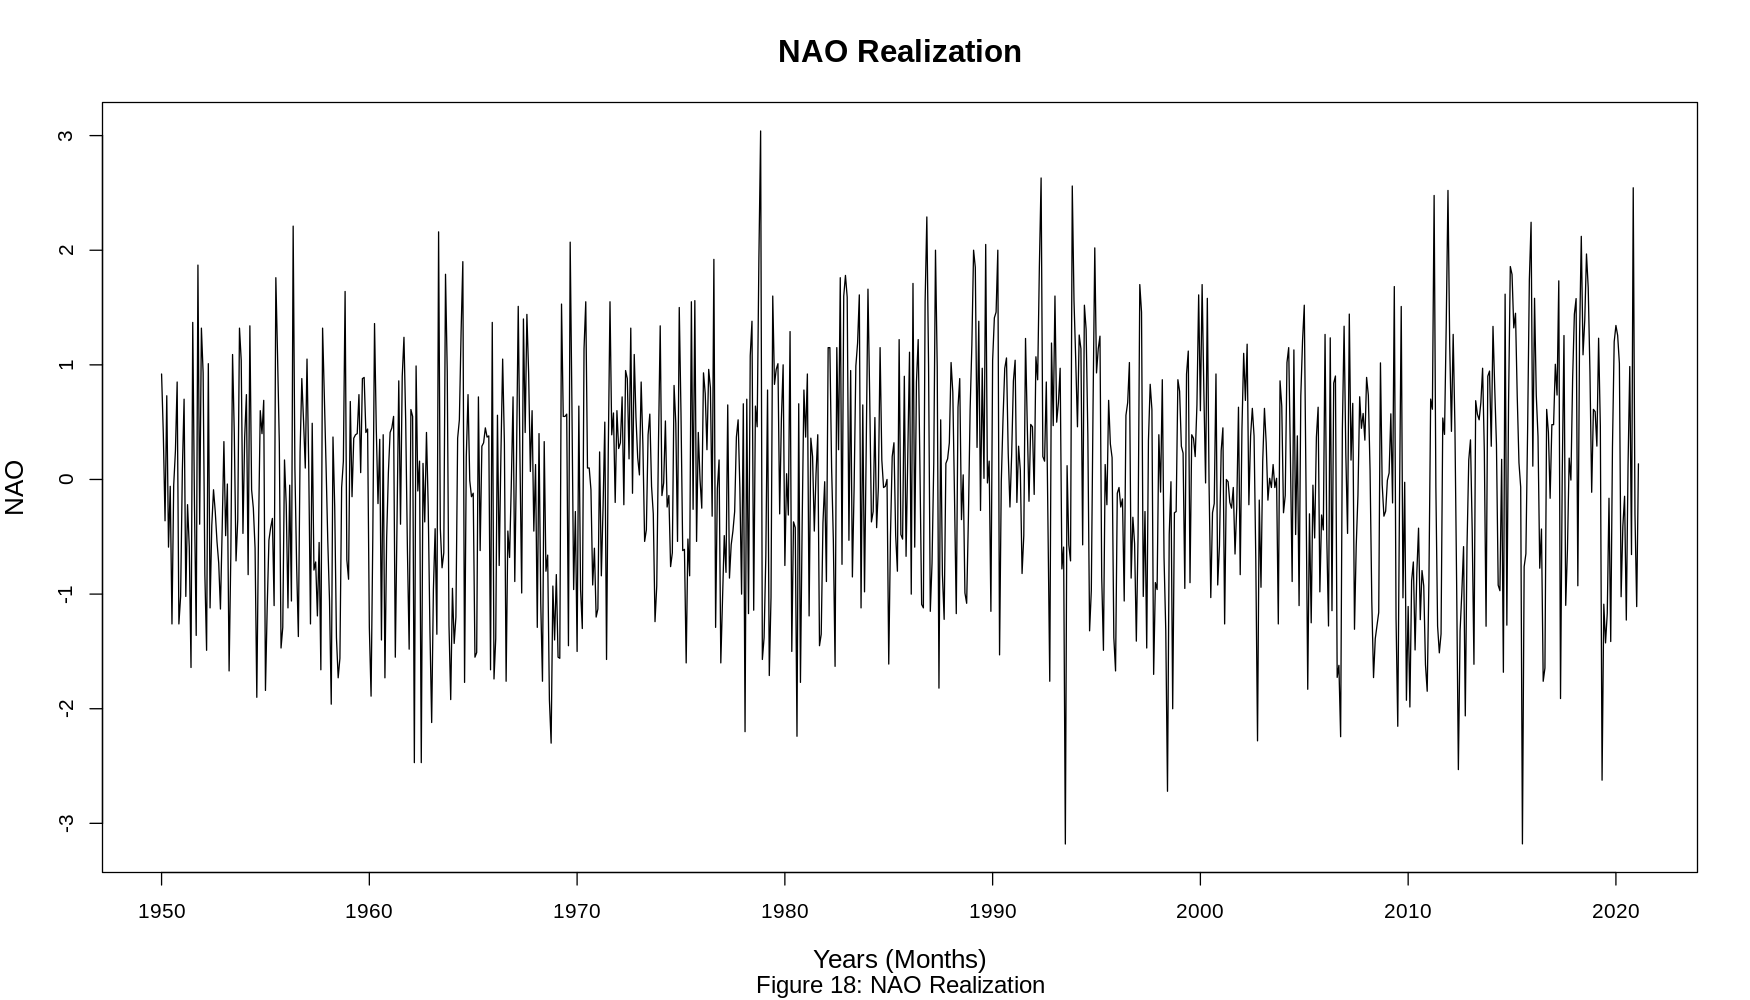

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25, cex.sub = 1.15)
plot(nao.ts, type ='l', lty = 1, xlab = 'Years (Months)', 
    ylab = 'NAO', main='NAO Realization', 
    sub = "Figure 18: NAO Realization")

#### 4.4.2 NAO Periodogram

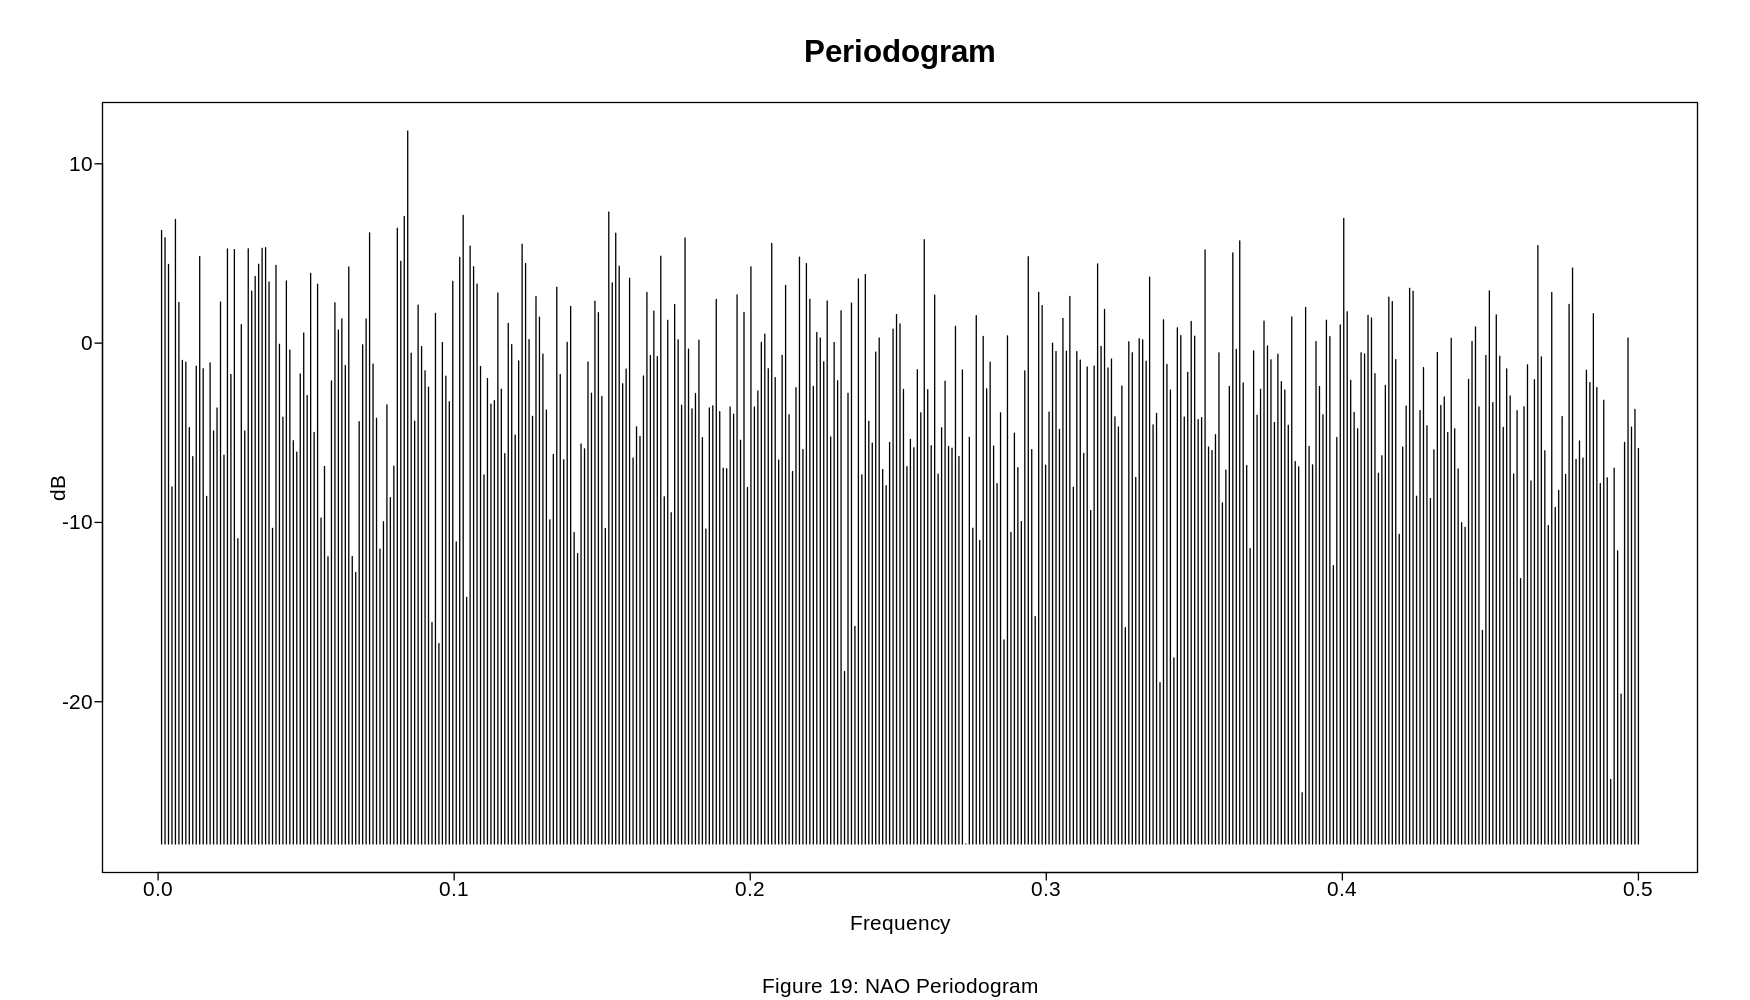

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25)
nao_periodogram <- period.wge(nao.ts)
title(sub = "Figure 19: NAO Periodogram")

#### 4.4.3 NAO Parzen Window

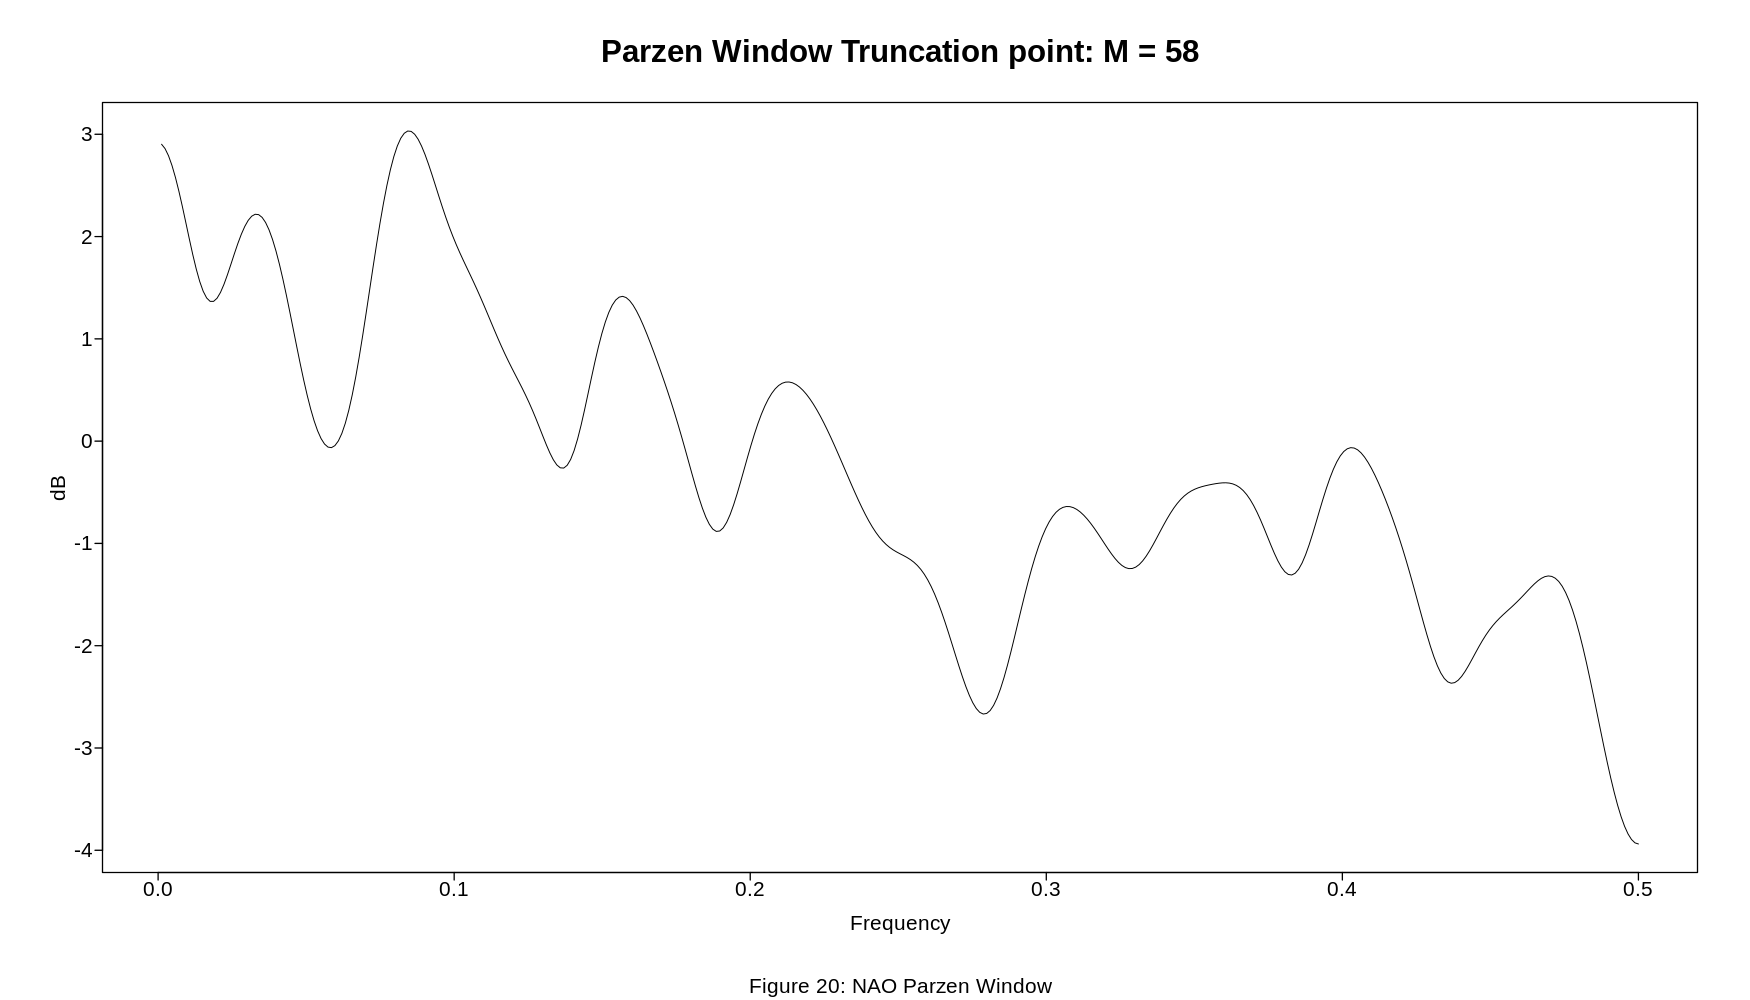

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25)
nao_parzen_window <- parzen.wge(nao.ts)
title(sub = "Figure 20: NAO Parzen Window")

#### 4.4.4 NAO Dominant Frequency and Periodic/Aperiodic Behavior

In [ ]:
f1 <- nao_periodogram$freq[which.max(nao_periodogram$pgram)]
cat("NAO Dominant Frequency: ", f1, "\n")
cat("NAO Period: ", 1/f1, "\n")

NAO Dominant Frequency:  0.08430913 
NAO Period:  11.86111 


#### 4.4.5 NAO Autocorrelation

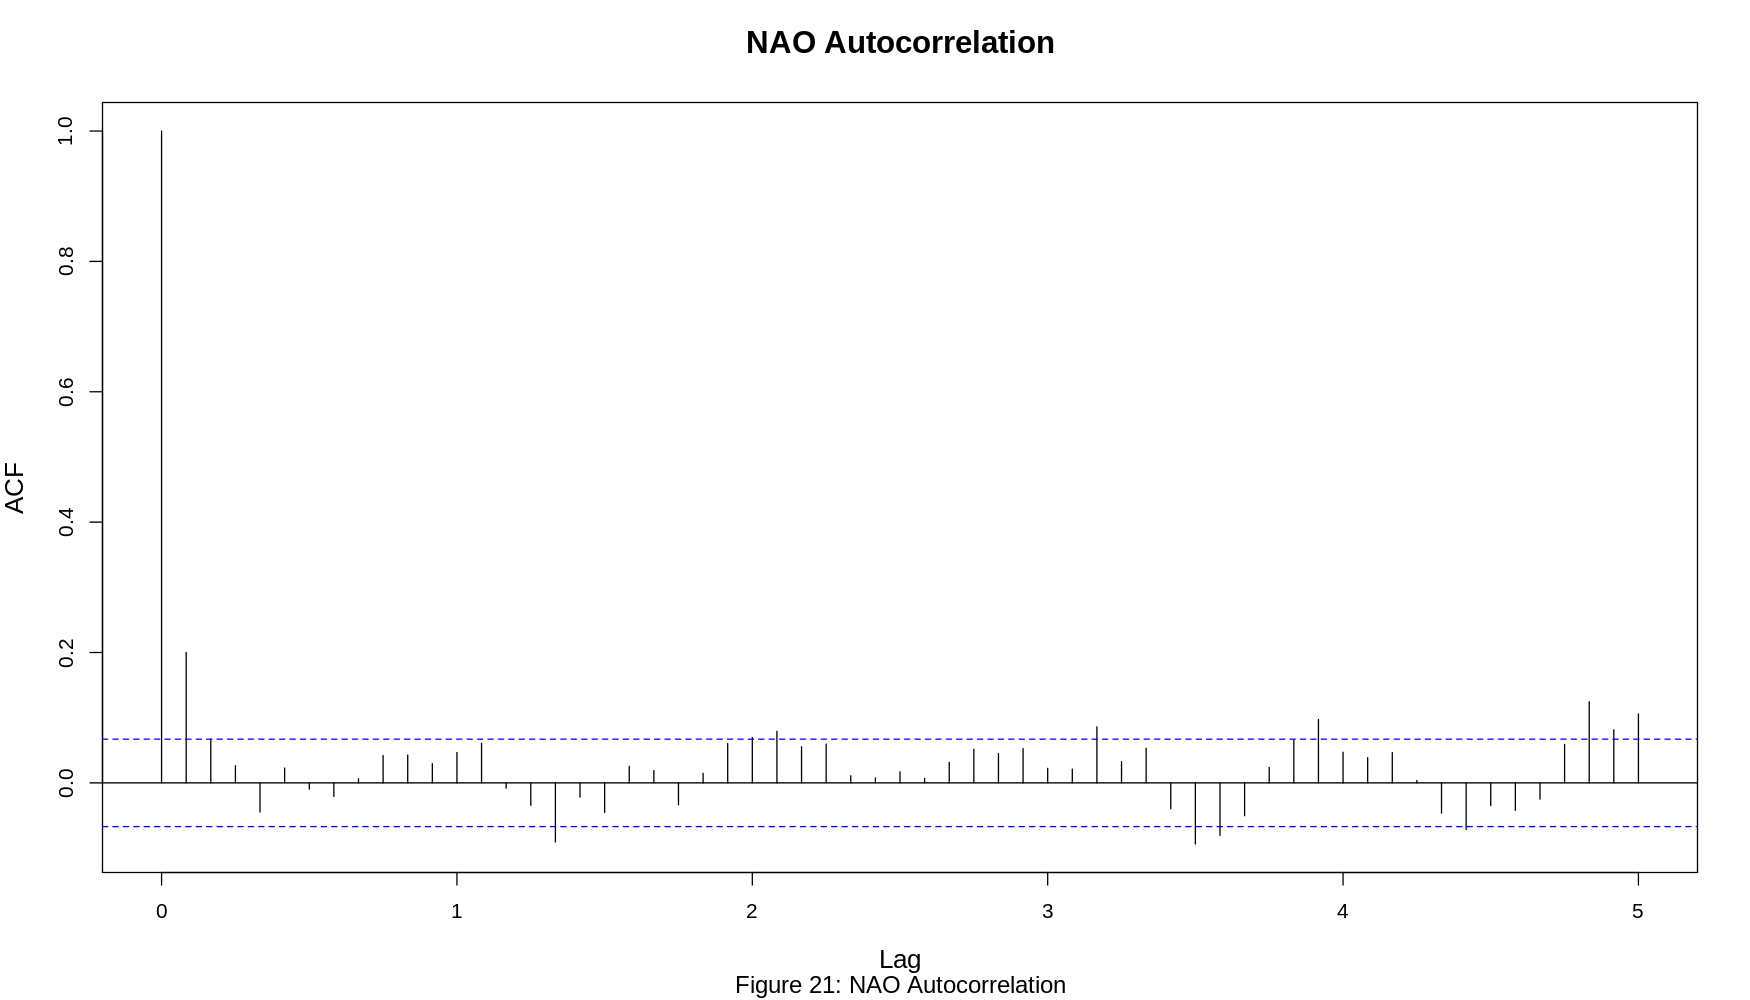

In [ ]:
options(repr.plot.width=14, repr.plot.height=8, repr.plot.res = 125)
par(cex.main =  1.5, cex.lab = 1.25, cex.sub = 1.15)
acf(nao.ts, main = 'NAO Autocorrelation', sub = 'Figure 21: NAO Autocorrelation', lag.max = 60)

## 5. Discussion and Conclusions 

For this lab, four different data sets were retrieved so that figure 1 from the Lam et al. paper could be replicated and the data sets further explored. Those four main data sets being the Oceanic Niño Index (ONI), the Multi-variate ENSO Index (MEI), the International Disasters Database (EMDAT), and the world bank population datasets. This data was loaded and processes to its different formats for creating the visualization and analyzing different aspects of it. Next realizations, periodograms, parzen windows, and autocorrelation figures were created for each of the datasets.

\
Periodograms are based on the squared correlation between the time series and the sine/cosine waves of frequency, $f$. Parzen windows are a probability density function that acts as a method for smoothing the the sample spectrum by implementing a truncation point. Sample autocorrelation is calculated by the formula $\hat \rho_h = \frac{\hat \gamma_h}{\hat \gamma_0}$. To call and run these functions on the data, the tswge package was installed and loaded in as a library. These tools helped to make creating all the different figures a lot easier, however, there were times were it was hard to understand and make a direct comparison between the different visualizations. For this lab, the periodogram and parzen window were the most useful in getting more of the details behind the datasets like their dominant frequency and periodic or aperiodic behavior.

\
Along with these figures investigating the various components of the data, figure 1 from the paper was reproduced as can be seen in figure 1 of this notebook (section 4.1). Next, the years of El Niño events were determined and recorded. Similar to earlier, the different figures were also generated to try and find patterns between El Niño events/years. Finally I repeated the steps of loading data in and doing analysis for the North Atlantic Oscillation (NAO) index which was chosen as an outside dataset to test. 

\
The reconstruction of Figure 1 from the Lam et al. paper also ended up being figure 1 in this notebook and can be found under section 4.1. If you compare the reconstructed version to the original, there are some minor changes in the locations of a few of the points but for the main part it is really close to the actual visualizaiton.

\
Figures 2-5, section 4.2.1 in this notebook explores the ONI data. The ONI realization shows a clear oscillation and seems to have a period. Looking into the periodogram/parzen window further shows that period finding a dominant frequency at 0.02344666 and finding a period around 42.65 months, or approximately 3.5 years. 

\
Figures 6-9, section 4.2.2 in this notebook explores the MEI index data. The realization contained oscillations with various magnitudes and what looked to be somewhat of a periodic tendency. This was further clarified in the periodogram and parzen window were the dominant frequency could be determined, $f$ = 0.02328431. The period of the MEI data was around 43 months or roughly 3.6 years. The parzen window also seemed to have another peek which could explain some of the higher frequency oscillations that occur every once in a while in the plots of MEI. The autocorrelations of both the ONI data and the MEI data showed some correlation that was sinusoidal in nature but quickly dampened as the lag increased.

\
Figures 10-13, section 4.2.3 in this notebook, explores the PAD data. The realization shows less oscillations and does not seem to have nearly as clear sign of periodicity. The periodogram and the resulting parzen window reveals three different peaks and thus three different dominant frequencies and periods. The three frequencies are: 0.462963, 0.2592593, and 0.1296296. The three periods are 2.16 years, 3.857143 years, and 7.714286 years. The autocorrelation plot reveals negligible correlation for PAD. 

\
For the El Niño Years, I decided to plot two different timeseries. The first was the binary version of El Niño Years as it contained a 1 if it was an El Niño year or a zero if not. The other timeseries that was put underneath the afformented plot was the instensity level of the El Niño years. The intensity level was set in accordance to the standards defined in the Lam et al. paper: where 0 = weak, 1 = moderate, 2 = strong, 3 = very strong, and -1 represents where the ONI index values did not fall into an intensity category of El Niño. While there are some difference between the binary and intensity version, for the most part they seem to come to the same conclusion. Finally the periodogram and parzen window of El Niño years revealed the El Niño Binary Dominant Frequency is 0.01289566 and the El Niño Intensity Dominant Frequency is 0.01758499. The El Niño Binary Period is 77.54545 months, or El Niño years occurring around every 6 years compared to the El Niño Intensity Period of 56.86667 months, or El Niño years occur around every 4.7 years. The range between these two periods seems to cover a decent amount of the variability in when El Niño years start. These figures can be seen in section 4.3 and are figures 14-17.

\
Figures 18-21 in section 4.4 investigate the North Atlantic Oscillation (NAO) index dataset. The realization for NAO showed high frequency oscillations and a lot of oscillations and therefore different peaks in the periodogram/parzen window. The most dominant frequency was 0.08430913 and the period was 11.86111 months. The autocorrelation plot showed little to no correlation along any of the lags.  

\
One of the challenges that I ran into was figuring out how to identify El Niño Years. I looked through various R documentations of classes and methods to come up with a solution that worked best. There were other smaller challenges in figuring out how to do different aspects that I also looked through documentation to solve.


## 6. References 

1. Wayne Woodward (2016). tswge: Applied Time Series Analysis. R package
  version 1.0.0. https://CRAN.R-project.org/package=tswge
2. Lam, H. C. Y., Haines, A., McGregor, G., Chan, E. Y. Y., & Hajat, S. (2019). Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle. *International Journal of Environmental Research and Public Health*, 16(17), 3146. [doi:10.3390/ijerph16173146](https://)
3. Davis, T. (2021). Applied Time Series Analysis: Course Notebook - Student Copy Lecture 1 [ipynb file]. William & Mary, Williamsburg VA. Retrieved from https://colab.research.google.com/drive/16vRnZEVY3we9jXIJotyDzVYjXH_gt8VX?usp=sharing.
4. Davis, T. (2021). Applied Time Series Analysis - Code Snippet Reading and processing data for Lab 1 [ipynb file]. William & Mary, Williamsburg VA. Retrieved from https://colab.research.google.com/drive/1LQYV32w2alxA8AMwlJC2PHjAyfs58I5M?usp=sharing#scrollTo=DscyF6Xddqta.
5. window function. (n.d.). Retrieved March 05, 2021, from https://www.rdocumentation.org/packages/stats/versions/3.1.1/topics/window
6. cycle function. (n.d.). Retrieved March 05, 2021, from https://www.rdocumentation.org/packages/cubing/versions/1.0-5/topics/cycle
7. subset function. (n.d.). Retrieved March 05, 2021, from https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/subset
